# Import Modules

In [50]:
import os, sys
import pandas as pd
import numpy as np
import datetime as dt
from pprint import pprint
import csv
import itertools as it
from prettytable import PrettyTable
from nanrms import *
from handover import *
from mask import *
import matplotlib.pylab as plt
import seaborn as sns
%config InlineBackend.figure_format = 'retina'  # 提高 jupyter notebook 的圖形顯示解析度
# plt.style.use('ggplot')

pd.set_option('display.max_columns', 200)
# pd.set_option('display.max_rows', 200)

first_time = False

datadir = "/Users/jackbedford/Desktop/MOXA/Code/data"
exp = "_Bandlock_Udp_B1_B3_B7_B8_RM500Q"
devices = [
    'qc00',
    # 'qc01',
    'qc02',
    'qc03',
]
schemes = [
    'B1',
    # 'B3',
    'B7',
    'B8',
]
dates = {
    "2023-03-15": [*['#{:02d}'.format(i+1) for i in range(1, 4)], '#06'],
    "2023-03-16": ['#{:02d}'.format(i+1) for i in range(16)],
}

# Collect Data Files

* 跑過第一輪之後就可以註解掉（已存到 pickle files），或將 block 1 的 first_time 改成 False

In [51]:
def set_data(df):
    df['seq'] = df['seq'].astype('Int32')
    df['rpkg'] = df['rpkg'].astype('Int8')
    df['frame_id'] = df['frame_id'].astype('Int32')
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    df['xmit_time'] = pd.to_datetime(df['xmit_time'])
    df['arr_time'] = pd.to_datetime(df['arr_time'])
    df['Timestamp_epoch'] = df['Timestamp_epoch'].astype('float32')
    df['xmit_time_epoch'] = df['xmit_time_epoch'].astype('float32')
    df['arr_time_epoch'] = df['arr_time_epoch'].astype('float32')
    df['lost'] = df['lost'].astype('boolean')
    df['excl'] = df['excl'].astype('boolean')
    df['latency'] = df['latency'].astype('float32')
    return df

## Uplink

In [52]:
if first_time:
    i = -1
    dfs_ul = []
    for date, traces in dates.items():
        for trace in traces:
            i += 1
            if i in [16,17,18,19]:
                dfs_ul.append([pd.DataFrame()]*len(devices))
                continue
            dfs_ul.append([])
            st, et = [], []
            for j, (dev, schm) in enumerate(zip(devices, schemes)):
                data = os.path.join(datadir, date, exp, dev, trace, 'data', 'udp_uplk_loss_latency.csv')
                print(data, os.path.isfile(data))
                # print(i, j)
                df = pd.read_csv(data)
                df = set_data(df)
                dfs_ul[i].append(df.copy())
                st.append(df['seq'].array[0])
                et.append(df['seq'].array[-1])
            st, et = max(st), min(et)
            for j, (dev, schm) in enumerate(zip(devices, schemes)):
                dfs_ul[i][j] = dfs_ul[i][j][(dfs_ul[i][j]['seq'] >= st) & (dfs_ul[i][j]['seq'] <= et)].reset_index(drop=True)
    print(len(dfs_ul))

## Downlink

In [53]:
if first_time:
    i = -1
    dfs_dl = []
    for date, traces in dates.items():
        for trace in traces:
            i += 1
            if i in [0,1,2,3]:
                dfs_dl.append([pd.DataFrame()]*len(devices))
                continue
            dfs_dl.append([])
            st, et = [], []
            for j, (dev, schm) in enumerate(zip(devices, schemes)):
                data = os.path.join(datadir, date, exp, dev, trace, 'data', 'udp_dnlk_loss_latency.csv')
                print(data, os.path.isfile(data))
                # print(i, j)
                df = pd.read_csv(data)
                df = set_data(df)
                dfs_dl[i].append(df.copy())
                st.append(df['seq'].array[0])
                et.append(df['seq'].array[-1])
            st, et = max(st), min(et)
            for j, (dev, schm) in enumerate(zip(devices, schemes)):
                dfs_dl[i][j] = dfs_dl[i][j][(dfs_dl[i][j]['seq'] >= st) & (dfs_dl[i][j]['seq'] <= et)].reset_index(drop=True)
    print(len(dfs_dl))

## Handover

In [54]:
if first_time:
    i = -1
    dfs_ho = []
    for date, traces in dates.items():
        for trace in traces:
            i += 1
            dfs_ho.append([])
            for j, (dev, schm) in enumerate(zip(devices, schemes)):
                path = os.path.join(datadir, date, exp, dev, trace, 'data')
                data = os.path.join(path, [s for s in os.listdir(path) if s.startswith('diag_log_') and s.endswith('_rrc.csv')][0])
                print(data, os.path.isfile(data))
                # print(i, j)
                df = pd.read_csv(data)
                df, _, _ = mi_parse_ho(df, tz=8)
                dfs_ho[i].append(df.copy())
                ### add ho info to packet data
                E = get_ho_interval(dfs_ho[i][j].copy())
                dfs_ul[i][j] = label_ho_info(dfs_ul[i][j].copy(), E, mode='ul') if not dfs_ul[i][j].empty else pd.DataFrame()
                dfs_dl[i][j] = label_ho_info(dfs_dl[i][j].copy(), E, mode='dl') if not dfs_dl[i][j].empty else pd.DataFrame()
                if not dfs_ul[i][j].empty:
                    dfs_ul[i][j].to_pickle(os.path.join(path, 'udp_uplk_loss_latency_ho.pkl'))
                if not dfs_dl[i][j].empty:
                    dfs_dl[i][j].to_pickle(os.path.join(path, 'udp_dnlk_loss_latency_ho.pkl'))
    print(len(dfs_ho))

# Statistics

In [55]:
if not first_time:
    i = -1
    dfs_ul = []
    for date, traces in dates.items():
        for trace in traces:
            i += 1
            if i in [16,17,18,19]:
                dfs_ul.append([pd.DataFrame()]*len(devices))
                continue
            dfs_ul.append([])
            st, et = [], []
            for j, (dev, schm) in enumerate(zip(devices, schemes)):
                data = os.path.join(datadir, date, exp, dev, trace, 'data', 'udp_uplk_loss_latency_ho.pkl')
                print(data, os.path.isfile(data))
                # print(i, j)
                df = pd.read_pickle(data)
                df = set_data(df)
                dfs_ul[i].append(df.copy())
                st.append(df['seq'].array[0])
                et.append(df['seq'].array[-1])
            st, et = max(st), min(et)
            for j, (dev, schm) in enumerate(zip(devices, schemes)):
                dfs_ul[i][j] = dfs_ul[i][j][(dfs_ul[i][j]['seq'] >= st) & (dfs_ul[i][j]['seq'] <= et)].reset_index(drop=True)
    print(len(dfs_ul))

/Users/jackbedford/Desktop/MOXA/Code/data/2023-03-15/_Bandlock_Udp_B1_B3_B7_B8_RM500Q/qc00/#02/data/udp_uplk_loss_latency_ho.pkl True
/Users/jackbedford/Desktop/MOXA/Code/data/2023-03-15/_Bandlock_Udp_B1_B3_B7_B8_RM500Q/qc02/#02/data/udp_uplk_loss_latency_ho.pkl True
/Users/jackbedford/Desktop/MOXA/Code/data/2023-03-15/_Bandlock_Udp_B1_B3_B7_B8_RM500Q/qc03/#02/data/udp_uplk_loss_latency_ho.pkl True
/Users/jackbedford/Desktop/MOXA/Code/data/2023-03-15/_Bandlock_Udp_B1_B3_B7_B8_RM500Q/qc00/#03/data/udp_uplk_loss_latency_ho.pkl True
/Users/jackbedford/Desktop/MOXA/Code/data/2023-03-15/_Bandlock_Udp_B1_B3_B7_B8_RM500Q/qc02/#03/data/udp_uplk_loss_latency_ho.pkl True
/Users/jackbedford/Desktop/MOXA/Code/data/2023-03-15/_Bandlock_Udp_B1_B3_B7_B8_RM500Q/qc03/#03/data/udp_uplk_loss_latency_ho.pkl True
/Users/jackbedford/Desktop/MOXA/Code/data/2023-03-15/_Bandlock_Udp_B1_B3_B7_B8_RM500Q/qc00/#04/data/udp_uplk_loss_latency_ho.pkl True
/Users/jackbedford/Desktop/MOXA/Code/data/2023-03-15/_Bandlock

In [56]:
if not first_time:
    i = -1
    dfs_dl = []
    for date, traces in dates.items():
        for trace in traces:
            i += 1
            if i in [0,1,2,3]:
                dfs_dl.append([pd.DataFrame()]*len(devices))
                continue
            dfs_dl.append([])
            st, et = [], []
            for j, (dev, schm) in enumerate(zip(devices, schemes)):
                data = os.path.join(datadir, date, exp, dev, trace, 'data', 'udp_dnlk_loss_latency_ho.pkl')
                print(data, os.path.isfile(data))
                # print(i, j)
                df = pd.read_pickle(data)
                df = set_data(df)
                dfs_dl[i].append(df.copy())
                st.append(df['seq'].array[0])
                et.append(df['seq'].array[-1])
            st, et = max(st), min(et)
            for j, (dev, schm) in enumerate(zip(devices, schemes)):
                dfs_dl[i][j] = dfs_dl[i][j][(dfs_dl[i][j]['seq'] >= st) & (dfs_dl[i][j]['seq'] <= et)].reset_index(drop=True)
    print(len(dfs_dl))

/Users/jackbedford/Desktop/MOXA/Code/data/2023-03-16/_Bandlock_Udp_B1_B3_B7_B8_RM500Q/qc00/#01/data/udp_dnlk_loss_latency_ho.pkl True
/Users/jackbedford/Desktop/MOXA/Code/data/2023-03-16/_Bandlock_Udp_B1_B3_B7_B8_RM500Q/qc02/#01/data/udp_dnlk_loss_latency_ho.pkl True
/Users/jackbedford/Desktop/MOXA/Code/data/2023-03-16/_Bandlock_Udp_B1_B3_B7_B8_RM500Q/qc03/#01/data/udp_dnlk_loss_latency_ho.pkl True
/Users/jackbedford/Desktop/MOXA/Code/data/2023-03-16/_Bandlock_Udp_B1_B3_B7_B8_RM500Q/qc00/#02/data/udp_dnlk_loss_latency_ho.pkl True
/Users/jackbedford/Desktop/MOXA/Code/data/2023-03-16/_Bandlock_Udp_B1_B3_B7_B8_RM500Q/qc02/#02/data/udp_dnlk_loss_latency_ho.pkl True
/Users/jackbedford/Desktop/MOXA/Code/data/2023-03-16/_Bandlock_Udp_B1_B3_B7_B8_RM500Q/qc03/#02/data/udp_dnlk_loss_latency_ho.pkl True
/Users/jackbedford/Desktop/MOXA/Code/data/2023-03-16/_Bandlock_Udp_B1_B3_B7_B8_RM500Q/qc00/#03/data/udp_dnlk_loss_latency_ho.pkl True
/Users/jackbedford/Desktop/MOXA/Code/data/2023-03-16/_Bandlock

In [57]:
df = dfs_ul[0][0].copy()

plr = round(df.lost.mean() * 100, 4)
elr = round(df[~df.lost].excl.mean() * 100, 4)
plelr = round(df.excl.mean() * 100, 4)
avg_l = round(df[~df.lost].latency.mean(), 6)
min_l = round(df[~df.lost].latency.min(), 6)
max_l = round(df[~df.lost].latency.max(), 6)
mdn_l = round(df[~df.lost].latency.median(), 6)
var_l = round(df[~df.lost].latency.var(), 6)
std_l = round(df[~df.lost].latency.std(), 6)
jitter = round(df.loc[~df.lost, 'latency'].diff().abs().mean(), 6)

print('packet loss rate (%):      ', plr)
print('excessive latency rate (%):', elr)
print('plr + elr (%):             ', plelr)
print('average latency:           ', avg_l)
print('min latency:               ', min_l)
print('max latency:               ', max_l)
print('median latency:            ', mdn_l)
print('latency variance:          ', var_l)
print('latency standard deviation:', std_l)
print('latency jitter:            ', jitter)

display(df)

packet loss rate (%):       0.1094
excessive latency rate (%): 0.0007
plr + elr (%):              0.1101
average latency:            0.015278
min latency:                0.004967
max latency:                0.100752
median latency:             0.014498
latency variance:           1.5e-05
latency standard deviation: 0.003862
latency jitter:             0.001796


,seq,rpkg,frame_id,Timestamp,Timestamp_epoch,lost,excl,latency,xmit_time,xmit_time_epoch,arr_time,arr_time_epoch,ho_index,ho_stage,ho_type,ho_type1,ho_type2,ho_scel,ho_cause,ho_intr,ho_ePCI,ho_earfcn,ho_nrPCI,ho_ePCI1,ho_earfcn1,ho_nrPCI1,ho_type0,_ho_type,_ho_type0,_ho_type1,_ho_type2
0,2501,1,2500,2023-03-15 15:19:18.247391,1.678865e+09,False,False,0.013518,2023-03-15 15:19:18.247416,1.678865e+09,2023-03-15 15:19:18.260909,1.678865e+09,-1,-,stable,stable,stable,0,NaN,NaN,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,stable,stable,stable,stable,stable
1,2502,1,2501,2023-03-15 15:19:18.249392,1.678865e+09,False,False,0.013431,2023-03-15 15:19:18.249455,1.678865e+09,2023-03-15 15:19:18.262823,1.678865e+09,-1,-,stable,stable,stable,0,NaN,NaN,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,stable,stable,stable,stable,stable
2,2503,1,2502,2023-03-15 15:19:18.251392,1.678865e+09,False,False,0.014407,2023-03-15 15:19:18.251416,1.678865e+09,2023-03-15 15:19:18.265799,1.678865e+09,-1,-,stable,stable,stable,0,NaN,NaN,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,stable,stable,stable,stable,stable
3,2504,1,2503,2023-03-15 15:19:18.253392,1.678865e+09,False,False,0.017362,2023-03-15 15:19:18.253416,1.678865e+09,2023-03-15 15:19:18.270754,1.678865e+09,-1,-,stable,stable,stable,0,NaN,NaN,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,stable,stable,stable,stable,stable
4,2505,1,2504,2023-03-15 15:19:18.255392,1.678865e+09,False,False,0.015362,2023-03-15 15:19:18.255422,1.678865e+09,2023-03-15 15:19:18.270754,1.678865e+09,-1,-,stable,stable,stable,0,NaN,NaN,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,stable,stable,stable,stable,stable
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137995,140496,1,140386,2023-03-15 15:23:54.250288,1.678865e+09,False,False,0.013505,2023-03-15 15:23:54.250312,1.678865e+09,2023-03-15 15:23:54.263793,1.678865e+09,13,before,LTE_HO,intra_freq,inter_enb,0,NaN,0.015958,122,525,<NA>,178,525,<NA>,LTE_HO,before_LTE_HO,before_LTE_HO,before_intra_freq,before_inter_enb
137996,140497,1,140387,2023-03-15 15:23:54.252289,1.678865e+09,False,False,0.015495,2023-03-15 15:23:54.252321,1.678865e+09,2023-03-15 15:23:54.267784,1.678865e+09,13,before,LTE_HO,intra_freq,inter_enb,0,NaN,0.015958,122,525,<NA>,178,525,<NA>,LTE_HO,before_LTE_HO,before_LTE_HO,before_intra_freq,before_inter_enb
137997,140498,1,140388,2023-03-15 15:23:54.254289,1.678865e+09,False,False,0.023642,2023-03-15 15:23:54.254321,1.678865e+09,2023-03-15 15:23:54.277931,1.678865e+09,13,before,LTE_HO,intra_freq,inter_enb,0,NaN,0.015958,122,525,<NA>,178,525,<NA>,LTE_HO,before_LTE_HO,before_LTE_HO,before_intra_freq,before_inter_enb
137998,140499,1,140389,2023-03-15 15:23:54.256289,1.678865e+09,False,False,0.021642,2023-03-15 15:23:54.256318,1.678865e+09,2023-03-15 15:23:54.277931,1.678865e+09,13,before,LTE_HO,intra_freq,inter_enb,0,NaN,0.015958,122,525,<NA>,178,525,<NA>,LTE_HO,before_LTE_HO,before_LTE_HO,before_intra_freq,before_inter_enb


# Single Radio Analysis

In [58]:
sorter = ['stable',
          'LTE_HO','MN_HO','SN_HO','MNSN_HO','SN_Rel','SN_Setup','SN_Rel_MN_HO','SN_Setup_MN_HO',
          'SCG_Failure_t310-Expiry (0)','SCG_Failure_randomAccessProblem (1)','SCG_Failure_rlc-MaxNumRetx (2)','SCG_Failure_synchReconfigFailureSCG (3)',
          'SCG_Failure_scg-ReconfigFailure (4)','SCG_Failure_srb3-IntegrityFailure (5)','SCG_Failure_other-r16 (6)',
          'MCG_Failure_reconfigurationFailure (0)','MCG_Failure_handoverFailure (1)','MCG_Failure_otherFailure (2)',
          'NAS_Recovery_reconfigurationFailure (0)','NAS_Recovery_handoverFailure (1)','NAS_Recovery_otherFailure (2)']
# mcg failure types: https://www.sharetechnote.com/html/Handbook_LTE_RRC_ConnectionReestablishment.html (0)(1)(2)
# scg failure types: https://www.sharetechnote.com/html/5G/5G_Release17.html (1)(3)

print(len(sorter))
print(sorter)
table = pd.DataFrame(columns=['ho_count',
                              'ul_lost','ul_excl','ul_sent',
                              'dl_lost','dl_excl','dl_sent'],
                     index=sorter).fillna(0).reset_index().rename(columns={'index':'ho_type0'})
display(table)

22
['stable', 'LTE_HO', 'MN_HO', 'SN_HO', 'MNSN_HO', 'SN_Rel', 'SN_Setup', 'SN_Rel_MN_HO', 'SN_Setup_MN_HO', 'SCG_Failure_t310-Expiry (0)', 'SCG_Failure_randomAccessProblem (1)', 'SCG_Failure_rlc-MaxNumRetx (2)', 'SCG_Failure_synchReconfigFailureSCG (3)', 'SCG_Failure_scg-ReconfigFailure (4)', 'SCG_Failure_srb3-IntegrityFailure (5)', 'SCG_Failure_other-r16 (6)', 'MCG_Failure_reconfigurationFailure (0)', 'MCG_Failure_handoverFailure (1)', 'MCG_Failure_otherFailure (2)', 'NAS_Recovery_reconfigurationFailure (0)', 'NAS_Recovery_handoverFailure (1)', 'NAS_Recovery_otherFailure (2)']


,ho_type0,ho_count,ul_lost,ul_excl,ul_sent,dl_lost,dl_excl,dl_sent
0,stable,0,0,0,0,0,0,0
1,LTE_HO,0,0,0,0,0,0,0
2,MN_HO,0,0,0,0,0,0,0
3,SN_HO,0,0,0,0,0,0,0
4,MNSN_HO,0,0,0,0,0,0,0
5,SN_Rel,0,0,0,0,0,0,0
6,SN_Setup,0,0,0,0,0,0,0
7,SN_Rel_MN_HO,0,0,0,0,0,0,0
8,SN_Setup_MN_HO,0,0,0,0,0,0,0
9,SCG_Failure_t310-Expiry (0),0,0,0,0,0,0,0


In [59]:
def single_radio_stats(df_main):
    ### Uplink
    if df_main[0].empty:
        table = pd.DataFrame(columns=['ho_type0','ho_count',
                                      'ul_lost','ul_excl','ul_sent'])
    else:
        df_main[0]['ho_type0'] = df_main[0]['ho_type0'].cat.set_categories(sorter)
        ## ul lost
        table = df_main[0].loc[df_main[0]['lost'], ['ho_type0']].value_counts()
        table = pd.DataFrame(table).reset_index().rename(columns={0:'ul_lost'})
        ## ul excl
        table1 = df_main[0].loc[~df_main[0]['lost'] & df_main[0]['excl'], ['ho_type0']].value_counts()
        table1 = pd.DataFrame(table1).reset_index().rename(columns={0:'ul_excl'})
        table = table.merge(table1, on=['ho_type0'], how='outer') \
            .sort_values(['ho_type0']).reset_index(drop=True).fillna(0)
        ## ul total sent
        table1 = df_main[0].loc[:, ['ho_type0']].value_counts()
        table1 = pd.DataFrame(table1).reset_index().rename(columns={0:'ul_sent'})
        table = table.merge(table1, on=['ho_type0'], how='outer') \
            .sort_values(['ho_type0']).reset_index(drop=True).fillna(0)
        # ## ul PLR
        # table['ul_PLR'] = (table['ul_lost'] / table['ul_sent'] * 100).round(2)
        # ## ul ELR
        # table['ul_ELR'] = (table['ul_excl'] / (table['ul_sent'] - table['ul_lost']) * 100).round(2)
    # display(table)
    
    ### Downlink
    if df_main[1].empty:
        _table = pd.DataFrame(columns=['ho_type0','ho_count',
                                       'dl_lost','dl_excl','dl_sent'])
    else:
        df_main[1]['ho_type0'] = df_main[1]['ho_type0'].cat.set_categories(sorter)
        ## dl lost
        _table = df_main[1].loc[df_main[1]['lost'], ['ho_type0']].value_counts()
        _table = pd.DataFrame(_table).reset_index().rename(columns={0:'dl_lost'})
        ## dl excl
        _table1 = df_main[1].loc[~df_main[1]['lost'] & df_main[1]['excl'], ['ho_type0']].value_counts()
        _table1 = pd.DataFrame(_table1).reset_index().rename(columns={0:'dl_excl'})
        _table = _table.merge(_table1, on=['ho_type0'], how='outer') \
            .sort_values(['ho_type0']).reset_index(drop=True).fillna(0)
        ## dl total sent
        _table1 = df_main[1].loc[:, ['ho_type0']].value_counts()
        _table1 = pd.DataFrame(_table1).reset_index().rename(columns={0:'dl_sent'})
        _table = _table.merge(_table1, on=['ho_type0'], how='outer') \
            .sort_values(['ho_type0']).reset_index(drop=True).fillna(0)
        # ## dl PLR
        # _table['dl_PLR'] = (_table['dl_lost'] / _table['dl_sent'] * 100).round(2)
        # ## dl ELR
        # _table['dl_ELR'] = (_table['dl_excl'] / (_table['dl_sent'] - _table['dl_lost']) * 100).round(2)
    # display(_table)
    
    ### Merge table
    table = table.merge(_table, on=['ho_type0'], how='outer') \
        .sort_values(['ho_type0']).reset_index(drop=True).fillna(0)
    
    ### Count HO
    df = df_main[0].copy() if not df_main[0].empty else df_main[1].copy()
    df['ho_type0'] = df['ho_type0'].cat.set_categories(sorter)
    tb_tmp = df.loc[:, ['ho_type0', 'ho_index']].value_counts().reset_index()
    tb_dict = tb_tmp['ho_type0'].value_counts().to_dict()
    table['ho_count'] = pd.Series(dtype='Int32')
    for key, val in tb_dict.items():
        table.loc[table['ho_type0'] == key, 'ho_count'] = val
    # table = table.fillna(0)

    ## reindex
    table = table.reindex(['ho_type0','ho_count',
                            'ul_lost','ul_excl','ul_sent',
                            'dl_lost','dl_excl','dl_sent',], axis=1)
    ## set dtypes
    table['ul_lost'] = table['ul_lost'].astype('Int64')
    table['ul_excl'] = table['ul_excl'].astype('Int64')
    table['ul_sent'] = table['ul_sent'].astype('Int64')
    table['dl_lost'] = table['dl_lost'].astype('Int64')
    table['dl_excl'] = table['dl_excl'].astype('Int64')
    table['dl_sent'] = table['dl_sent'].astype('Int64')
    table['ho_count'] = table['ho_count'].astype('Int32')
    
    return table

def single_radio_merge(tb_list):
    table = tb_list[0].copy().set_index('ho_type0')
    for i in range(1, len(tb_list)):
        table = table.add(tb_list[i].copy().set_index('ho_type0'), fill_value=0)
    table = table.reset_index()
    return table

In [60]:
N = len(dfs_ul)
# xs = list(it.combinations(range(len(schemes)), 2))
xs = list(it.permutations(range(len(schemes)), 2))
print(xs)

table_list = []
for i in range(N):
# for i in range(1, 5):
    table = pd.DataFrame(columns=['ho_count',
                                  'ul_lost','ul_excl','ul_sent',
                                  'dl_lost','dl_excl','dl_sent'],
                         index=sorter).fillna(0).reset_index().rename(columns={'index':'ho_type0'})
    for x in xs:
        # print(i)
        # print(x[0], x[1])
        df_main = (dfs_ul[i][x[0]].copy(), dfs_dl[i][x[0]].copy())
        df_subr = (dfs_ul[i][x[1]].copy(), dfs_dl[i][x[1]].copy())
        ### Single Radio
        _table = single_radio_stats(df_main)
        table = single_radio_merge([table, _table])
        ### TODO: Add list to log tables under different schemes
    table_list.append(table)

print(len(table_list))
table_sr = single_radio_merge(table_list)
table_sr['ul_PLR'] = (table_sr['ul_lost'] / (table_sr['ul_sent'] + 1e-9) * 100).round(3)
table_sr['ul_ELR'] = (table_sr['ul_excl'] / ((table_sr['ul_sent'] + 1e-9) - table_sr['ul_lost']) * 100).round(3)
table_sr['dl_PLR'] = (table_sr['dl_lost'] / (table_sr['dl_sent'] + 1e-9) * 100).round(3)
table_sr['dl_ELR'] = (table_sr['dl_excl'] / ((table_sr['dl_sent'] + 1e-9) - table_sr['dl_lost']) * 100).round(3)
table_sr['ul_LPE'] = (table_sr['ul_lost'] / (table_sr['ho_count'] + 1e-9)).round(2)
table_sr['ul_EPE'] = (table_sr['ul_excl'] / (table_sr['ho_count'] + 1e-9)).round(2)
table_sr['dl_LPE'] = (table_sr['dl_lost'] / (table_sr['ho_count'] + 1e-9)).round(2)
table_sr['dl_EPE'] = (table_sr['dl_excl'] / (table_sr['ho_count'] + 1e-9)).round(2)
table_sr = table_sr.reindex(['ho_type0','ho_count',
                             'ul_lost','ul_excl','ul_sent',
                             'dl_lost','dl_excl','dl_sent',
                             'ul_PLR','ul_ELR','ul_LPE','ul_EPE',
                             'dl_PLR','dl_ELR','dl_LPE','dl_EPE',], axis=1)
table_sr['ho_count'] = table_sr['ho_count'].astype('Int32')
table_sr['ho_type0'] = table_sr['ho_type0'].astype('category')
table_sr['ho_type0'] = table_sr['ho_type0'].cat.set_categories(sorter)
table_sr = table_sr.sort_values(['ho_type0']).reset_index(drop=True)

[(0, 1), (0, 2), (1, 0), (1, 2), (2, 0), (2, 1)]
20


## Result

In [61]:
print(len(sorter))
print(table_sr.dtypes)
display(table_sr)
table_sr.to_pickle('table_sr.pkl')

22
ho_type0    category
ho_count       Int32
ul_lost        Int64
ul_excl        Int64
ul_sent        Int64
dl_lost        Int64
dl_excl        Int64
dl_sent        Int64
ul_PLR       Float64
ul_ELR       Float64
ul_LPE       Float64
ul_EPE       Float64
dl_PLR       Float64
dl_ELR       Float64
dl_LPE       Float64
dl_EPE       Float64
dtype: object


,ho_type0,ho_count,ul_lost,ul_excl,ul_sent,dl_lost,dl_excl,dl_sent,ul_PLR,ul_ELR,ul_LPE,ul_EPE,dl_PLR,dl_ELR,dl_LPE,dl_EPE
0,stable,120,3894,52804,10712426,14048,17918,10714170,0.036,0.493,32.45,440.03,0.131,0.167,117.07,149.32
1,LTE_HO,790,398,1926,452010,1024,16160,455924,0.088,0.426,0.5,2.44,0.225,3.552,1.3,20.46
2,MN_HO,1328,1406,11234,853324,12620,4520,830546,0.165,1.319,1.06,8.46,1.519,0.553,9.5,3.4
3,SN_HO,1298,312,26028,822626,4008,5060,823184,0.038,3.165,0.24,20.05,0.487,0.618,3.09,3.9
4,MNSN_HO,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,SN_Rel,18,2,148,2106,112,0,1320,0.095,7.034,0.11,8.22,8.485,0.0,6.22,0.0
6,SN_Setup,350,2966,14408,135422,23630,2532,130460,2.19,10.878,8.47,41.17,18.113,2.37,67.51,7.23
7,SN_Rel_MN_HO,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,SN_Setup_MN_HO,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,SCG_Failure_t310-Expiry (0),4,0,0,6000,1718,38,5560,0.0,0.0,0.0,0.0,30.899,0.989,429.5,9.5


# Dual Radio Analysis

In [62]:
# sorter1 = list(it.permutations(sorter, 2))
sorter1 = list(it.product(sorter, repeat=2))
sorter1 = ['+'.join([s[0],s[1]]) for s in sorter1]
print(len(sorter1))
print(sorter1)
sorter2 = [s.split('+')[0] for s in sorter1]
sorter3 = [s.split('+')[1] for s in sorter1]

table = pd.DataFrame(columns=['ho_count',
                              'ul_lost_m','ul_lost_ms','ul_lost_mlss',
                              'ul_excl_m','ul_excl_ms','ul_excl_mess','ul_sent',
                              'dl_lost_m','dl_lost_ms','dl_lost_mlss',
                              'dl_excl_m','dl_excl_ms','dl_excl_mess','dl_sent',],
                     index=[sorter2, sorter3, sorter1]).fillna(0).reset_index() \
                    .rename(columns={'level_0':'ho_type0_m', 'level_1':'ho_type0_s', 'level_2':'ho_type0_ms'})
display(table)

484
['stable+stable', 'stable+LTE_HO', 'stable+MN_HO', 'stable+SN_HO', 'stable+MNSN_HO', 'stable+SN_Rel', 'stable+SN_Setup', 'stable+SN_Rel_MN_HO', 'stable+SN_Setup_MN_HO', 'stable+SCG_Failure_t310-Expiry (0)', 'stable+SCG_Failure_randomAccessProblem (1)', 'stable+SCG_Failure_rlc-MaxNumRetx (2)', 'stable+SCG_Failure_synchReconfigFailureSCG (3)', 'stable+SCG_Failure_scg-ReconfigFailure (4)', 'stable+SCG_Failure_srb3-IntegrityFailure (5)', 'stable+SCG_Failure_other-r16 (6)', 'stable+MCG_Failure_reconfigurationFailure (0)', 'stable+MCG_Failure_handoverFailure (1)', 'stable+MCG_Failure_otherFailure (2)', 'stable+NAS_Recovery_reconfigurationFailure (0)', 'stable+NAS_Recovery_handoverFailure (1)', 'stable+NAS_Recovery_otherFailure (2)', 'LTE_HO+stable', 'LTE_HO+LTE_HO', 'LTE_HO+MN_HO', 'LTE_HO+SN_HO', 'LTE_HO+MNSN_HO', 'LTE_HO+SN_Rel', 'LTE_HO+SN_Setup', 'LTE_HO+SN_Rel_MN_HO', 'LTE_HO+SN_Setup_MN_HO', 'LTE_HO+SCG_Failure_t310-Expiry (0)', 'LTE_HO+SCG_Failure_randomAccessProblem (1)', 'LTE_HO

,ho_type0_m,ho_type0_s,ho_type0_ms,ho_count,ul_lost_m,ul_lost_ms,ul_lost_mlss,ul_excl_m,ul_excl_ms,ul_excl_mess,ul_sent,dl_lost_m,dl_lost_ms,dl_lost_mlss,dl_excl_m,dl_excl_ms,dl_excl_mess,dl_sent
0,stable,stable,stable+stable,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,stable,LTE_HO,stable+LTE_HO,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,stable,MN_HO,stable+MN_HO,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,stable,SN_HO,stable+SN_HO,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,stable,MNSN_HO,stable+MNSN_HO,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
479,NAS_Recovery_otherFailure (2),MCG_Failure_handoverFailure (1),NAS_Recovery_otherFailure (2)+MCG_Failure_hand...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
480,NAS_Recovery_otherFailure (2),MCG_Failure_otherFailure (2),NAS_Recovery_otherFailure (2)+MCG_Failure_othe...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
481,NAS_Recovery_otherFailure (2),NAS_Recovery_reconfigurationFailure (0),NAS_Recovery_otherFailure (2)+NAS_Recovery_rec...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
482,NAS_Recovery_otherFailure (2),NAS_Recovery_handoverFailure (1),NAS_Recovery_otherFailure (2)+NAS_Recovery_han...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [63]:
def dual_radio_stats(df_main, df_subr):
    dfs = [pd.DataFrame(), pd.DataFrame()]
    
    ### Uplink
    if df_main[0].empty:
        table = pd.DataFrame(columns=['ho_type0_ms','ho_count',
                                      'ul_lost_m','ul_lost_ms','ul_lost_mlss',
                                      'ul_excl_m','ul_excl_ms','ul_excl_mess','ul_sent'])
    else:
        dfs[0] = pd.merge(df_main[0], df_subr[0], on=['seq'], suffixes=('_m','_s')).copy()
        # dfs[0]['ho_type0_m'] = dfs[0]['ho_type0_m'].cat.set_categories(sorter)
        # dfs[0]['ho_type0_s'] = dfs[0]['ho_type0_s'].cat.set_categories(sorter)
        dfs[0]['ho_type0_ms'] = dfs[0]['ho_type0_m'].astype('string') + '+' + dfs[0]['ho_type0_s'].astype('string')
        dfs[0]['ho_type0_ms'] = dfs[0]['ho_type0_ms'].astype('category')
        dfs[0]['ho_type0_ms'] = dfs[0]['ho_type0_ms'].cat.set_categories(sorter1)
        ## main ul lost
        table = dfs[0].loc[dfs[0]['lost_m'], ['ho_type0_ms']].value_counts()
        table = pd.DataFrame(table).reset_index().rename(columns={0:f'ul_lost_m'})
        ## system ul lost
        table1 = dfs[0].loc[dfs[0]['lost_m'] & dfs[0]['lost_s'], ['ho_type0_ms']].value_counts()
        table1 = pd.DataFrame(table1).reset_index().rename(columns={0:f'ul_lost_ms'})
        table = table.merge(table1, on=['ho_type0_ms'], how='outer') \
            .sort_values(['ho_type0_ms']).reset_index(drop=True).fillna(0)
        ## ul: main lost, subr safe
        table1 = dfs[0].loc[dfs[0]['lost_m'] & ~dfs[0]['lost_s'], ['ho_type0_ms']].value_counts()
        table1 = pd.DataFrame(table1).reset_index().rename(columns={0:f'ul_lost_mlss'})
        table = table.merge(table1, on=['ho_type0_ms'], how='outer') \
            .sort_values(['ho_type0_ms']).reset_index(drop=True).fillna(0)
        ## main ul excl
        table1 = dfs[0].loc[~dfs[0]['lost_m'] & dfs[0]['excl_m'], ['ho_type0_ms']].value_counts()
        table1 = pd.DataFrame(table1).reset_index().rename(columns={0:'ul_excl_m'})
        table = table.merge(table1, on=['ho_type0_ms'], how='outer') \
            .sort_values(['ho_type0_ms']).reset_index(drop=True).fillna(0)
        ## system ul excl
        table1 = dfs[0].loc[(~dfs[0]['lost_m'] & dfs[0]['excl_m']) & (dfs[0]['excl_s']), ['ho_type0_ms']].value_counts()
        table1 = pd.DataFrame(table1).reset_index().rename(columns={0:'ul_excl_ms'})
        table = table.merge(table1, on=['ho_type0_ms'], how='outer') \
            .sort_values(['ho_type0_ms']).reset_index(drop=True).fillna(0)
        ## ul: main excl (main not lost), subr safe (subr not lost)
        table1 = dfs[0].loc[(~dfs[0]['lost_m'] & dfs[0]['excl_m']) & (~dfs[0]['excl_s']), ['ho_type0_ms']].value_counts()
        table1 = pd.DataFrame(table1).reset_index().rename(columns={0:'ul_excl_mess'})
        table = table.merge(table1, on=['ho_type0_ms'], how='outer') \
            .sort_values(['ho_type0_ms']).reset_index(drop=True).fillna(0)
        ## ul total sent
        table1 = dfs[0].loc[:, ['ho_type0_ms']].value_counts()
        table1 = pd.DataFrame(table1).reset_index().rename(columns={0:'ul_sent'})
        table = table.merge(table1, on=['ho_type0_ms'], how='outer') \
            .sort_values(['ho_type0_ms']).reset_index(drop=True).fillna(0)
        # ## ul PLR
        # table['ul_PLR_m'] = (table['ul_lost_m'] / table['ul_sent'] * 100).round(2)
        # table['ul_PLR_ms'] = (table['ul_lost_ms'] / table['ul_sent'] * 100).round(2)
        # table['ul_PLR_mlss'] = (table['ul_lost_mlss'] / table['ul_sent'] * 100).round(2)
        # ## ul ELR
        # table['ul_ELR_m'] = (table['ul_excl_m'] / (table['ul_sent'] - table['ul_lost_ms']) * 100).round(2)
        # table['ul_ELR_ms'] = (table['ul_excl_ms'] / (table['ul_sent'] - table['ul_lost_ms']) * 100).round(2)
        # table['ul_ELR_mess'] = (table['ul_excl_mess'] / (table['ul_sent'] - table['ul_lost_mlss']) * 100).round(2)
    # display(table)
    
    ### Downlink
    if df_main[1].empty:
        _table = pd.DataFrame(columns=['ho_type0_ms','ho_count',
                                       'dl_lost_m','dl_lost_ms','dl_lost_mlss',
                                       'dl_excl_m','dl_excl_ms','dl_excl_mess','dl_sent'])
    else:
        dfs[1] = pd.merge(df_main[1], df_subr[1], on=['seq'], suffixes=('_m','_s')).copy()
        # dfs[1]['ho_type0_m'] = dfs[1]['ho_type0_m'].cat.set_categories(sorter)
        # dfs[1]['ho_type0_s'] = dfs[1]['ho_type0_s'].cat.set_categories(sorter)
        dfs[1]['ho_type0_ms'] = dfs[1]['ho_type0_m'].astype('string') + '+' + dfs[1]['ho_type0_s'].astype('string')
        dfs[1]['ho_type0_ms'] = dfs[1]['ho_type0_ms'].astype('category')
        dfs[1]['ho_type0_ms'] = dfs[1]['ho_type0_ms'].cat.set_categories(sorter1)
        ## main dl lost
        _table = dfs[1].loc[dfs[1]['lost_m'], ['ho_type0_ms']].value_counts()
        _table = pd.DataFrame(_table).reset_index().rename(columns={0:f'dl_lost_m'})
        ## system dl lost
        _table1 = dfs[1].loc[dfs[1]['lost_m'] & dfs[1]['lost_s'], ['ho_type0_ms']].value_counts()
        _table1 = pd.DataFrame(_table1).reset_index().rename(columns={0:f'dl_lost_ms'})
        _table = _table.merge(_table1, on=['ho_type0_ms'], how='outer') \
            .sort_values(['ho_type0_ms']).reset_index(drop=True).fillna(0)
        ## dl: main lost, subr safe
        _table1 = dfs[1].loc[dfs[1]['lost_m'] & ~dfs[1]['lost_s'], ['ho_type0_ms']].value_counts()
        _table1 = pd.DataFrame(_table1).reset_index().rename(columns={0:f'dl_lost_mlss'})
        _table = _table.merge(_table1, on=['ho_type0_ms'], how='outer') \
            .sort_values(['ho_type0_ms']).reset_index(drop=True).fillna(0)
        ## main dl excl
        _table1 = dfs[1].loc[~dfs[1]['lost_m'] & dfs[1]['excl_m'], ['ho_type0_ms']].value_counts()
        _table1 = pd.DataFrame(_table1).reset_index().rename(columns={0:'dl_excl_m'})
        _table = _table.merge(_table1, on=['ho_type0_ms'], how='outer') \
            .sort_values(['ho_type0_ms']).reset_index(drop=True).fillna(0)
        ## system dl excl
        _table1 = dfs[1].loc[(~dfs[1]['lost_m'] & dfs[1]['excl_m']) & (dfs[1]['excl_s']), ['ho_type0_ms']].value_counts()
        _table1 = pd.DataFrame(_table1).reset_index().rename(columns={0:'dl_excl_ms'})
        _table = _table.merge(_table1, on=['ho_type0_ms'], how='outer') \
            .sort_values(['ho_type0_ms']).reset_index(drop=True).fillna(0)
        ## dl: main excl (main not lost), subr safe (subr not lost)
        _table1 = dfs[1].loc[(~dfs[1]['lost_m'] & dfs[1]['excl_m']) & (~dfs[1]['excl_s']), ['ho_type0_ms']].value_counts()
        _table1 = pd.DataFrame(_table1).reset_index().rename(columns={0:'dl_excl_mess'})
        _table = _table.merge(_table1, on=['ho_type0_ms'], how='outer') \
            .sort_values(['ho_type0_ms']).reset_index(drop=True).fillna(0)
        ## dl total sent
        _table1 = dfs[1].loc[:, ['ho_type0_ms']].value_counts()
        _table1 = pd.DataFrame(_table1).reset_index().rename(columns={0:'dl_sent'})
        _table = _table.merge(_table1, on=['ho_type0_ms'], how='outer') \
            .sort_values(['ho_type0_ms']).reset_index(drop=True).fillna(0)
        # ## dl PLR
        # _table['dl_PLR_m'] = (_table['dl_lost_m'] / _table['dl_sent'] * 100).round(2)
        # _table['dl_PLR_ms'] = (_table['dl_lost_ms'] / _table['dl_sent'] * 100).round(2)
        # _table['dl_PLR_mlss'] = (_table['dl_lost_mlss'] / _table['dl_sent'] * 100).round(2)
        # ## dl ELR
        # _table['dl_ELR_m'] = (_table['dl_excl_m'] / (_table['dl_sent'] - _table['dl_lost_ms']) * 100).round(2)
        # _table['dl_ELR_ms'] = (_table['dl_excl_ms'] / (_table['dl_sent'] - _table['dl_lost_ms']) * 100).round(2)
        # _table['dl_ELR_mess'] = (_table['dl_excl_mess'] / (_table['dl_sent'] - _table['dl_lost_mlss']) * 100).round(2)
    # display(_table)

    ### Merge table
    table = table.merge(_table, on=['ho_type0_ms'], how='outer') \
        .sort_values(['ho_type0_ms']).reset_index(drop=True).fillna(0)
    
    ### Count HO
    df = dfs[0].copy() if not dfs[0].empty else dfs[1].copy()
    df['ho_type0_ms'] = df['ho_type0_m'].astype('string') + '+' + df['ho_type0_s'].astype('string')
    df['ho_type0_ms'] = df['ho_type0_ms'].astype('category')
    df['ho_type0_ms'] = df['ho_type0_ms'].cat.set_categories(sorter1)
    tb_tmp = df.loc[:, ['ho_type0_ms','ho_index_m','ho_index_s']].value_counts().reset_index()
    tb_dict = tb_tmp['ho_type0_ms'].value_counts().to_dict()
    table['ho_count'] = pd.Series(dtype='Int32')
    for key, val in tb_dict.items():
        table.loc[table['ho_type0_ms'] == key, 'ho_count'] = val
    # table = table.fillna(0)
    
    ## restore ho_type0_m & ho_type0_s
    table['ho_type0_m'] = [s[0] for s in table['ho_type0_ms'].str.split('+', n=1, expand=False)]
    table['ho_type0_s'] = [s[1] for s in table['ho_type0_ms'].str.split('+', n=1, expand=False)]
    table['ho_type0_m'] = table['ho_type0_m'].astype('category')
    table['ho_type0_s'] = table['ho_type0_s'].astype('category')

    ## sort by ho_type0_ms
    table['ho_type0_ms'] = table['ho_type0_ms'].cat.set_categories(sorter1)
    table = table.sort_values(['ho_type0_ms'])
    
    ## reindex
    table = table.reindex(['ho_type0_m','ho_type0_s','ho_count',
                           'ul_lost_m','ul_lost_ms','ul_lost_mlss',
                           'ul_excl_m','ul_excl_ms','ul_excl_mess','ul_sent',
                           'dl_lost_m','dl_lost_ms','dl_lost_mlss',
                           'dl_excl_m','dl_excl_ms','dl_excl_mess','dl_sent',
                           'ho_type0_ms'], axis=1)
    ## set dtypes
    table['ul_lost_m'] = table['ul_lost_m'].astype('Int64')
    table['ul_lost_ms'] = table['ul_lost_ms'].astype('Int64')
    table['ul_lost_mlss'] = table['ul_lost_mlss'].astype('Int64')
    table['ul_excl_m'] = table['ul_excl_m'].astype('Int64')
    table['ul_excl_ms'] = table['ul_excl_ms'].astype('Int64')
    table['ul_excl_mess'] = table['ul_excl_mess'].astype('Int64')
    table['ul_sent'] = table['ul_sent'].astype('Int64')
    table['dl_lost_m'] = table['dl_lost_m'].astype('Int64')
    table['dl_lost_ms'] = table['dl_lost_ms'].astype('Int64')
    table['dl_lost_mlss'] = table['dl_lost_mlss'].astype('Int64')
    table['dl_excl_m'] = table['dl_excl_m'].astype('Int64')
    table['dl_excl_ms'] = table['dl_excl_ms'].astype('Int64')
    table['dl_excl_mess'] = table['dl_excl_mess'].astype('Int64')
    table['dl_sent'] = table['dl_sent'].astype('Int64')
    table['ho_count'] = table['ho_count'].astype('Int32')
    
    return table

def dual_radio_merge(tb_list):
    table = tb_list[0].copy().set_index(['ho_type0_m','ho_type0_s','ho_type0_ms'])
    for i in range(1, len(tb_list)):
        table = table.add(tb_list[i].copy().set_index(['ho_type0_m','ho_type0_s','ho_type0_ms']), fill_value=0)
    table = table.reset_index()
    return table

In [64]:
N = len(dfs_ul)
# xs = list(it.combinations(range(len(schemes)), 2))
xs = list(it.permutations(range(len(schemes)), 2))
print(xs)

table_list = []
for i in range(N):
# for i in range(16, 17):
    sorter2 = [s.split('+')[0] for s in sorter1]
    sorter3 = [s.split('+')[1] for s in sorter1]
    table = pd.DataFrame(columns=['ho_count',
                              'ul_lost_m','ul_lost_ms','ul_lost_mlss',
                              'ul_excl_m','ul_excl_ms','ul_excl_mess','ul_sent',
                              'dl_lost_m','dl_lost_ms','dl_lost_mlss',
                              'dl_excl_m','dl_excl_ms','dl_excl_mess','dl_sent',],
                     index=[sorter2, sorter3, sorter1]).fillna(0).reset_index() \
                    .rename(columns={'level_0':'ho_type0_m', 'level_1':'ho_type0_s', 'level_2':'ho_type0_ms'})
    for x in xs:
        # print(i)
        # print(x[0], x[1])
        df_main = (dfs_ul[i][x[0]].copy(), dfs_dl[i][x[0]].copy())
        df_subr = (dfs_ul[i][x[1]].copy(), dfs_dl[i][x[1]].copy())
        ### Dual Radio
        _table = dual_radio_stats(df_main, df_subr)
        # display(_table)
        table = dual_radio_merge([table, _table])
        # display(table)
        ### TODO: Add list to log tables under different schemes
    table_list.append(table)

print(len(table_list))
table_dr = dual_radio_merge(table_list)
## ul PLR
table_dr['ul_PLR_m'] = (table_dr['ul_lost_m'] / (table_dr['ul_sent'] + 1e-9) * 100).round(5)
table_dr['ul_PLR_ms'] = (table_dr['ul_lost_ms'] / (table_dr['ul_sent'] + 1e-9) * 100).round(5)
table_dr['ul_PLR_mlss'] = (table_dr['ul_lost_mlss'] / (table_dr['ul_sent'] + 1e-9) * 100).round(5)
## ul ELR
table_dr['ul_ELR_m'] = (table_dr['ul_excl_m'] / ((table_dr['ul_sent'] + 1e-9) - table_dr['ul_lost_ms']) * 100).round(5)
table_dr['ul_ELR_ms'] = (table_dr['ul_excl_ms'] / ((table_dr['ul_sent'] + 1e-9) - table_dr['ul_lost_ms']) * 100).round(5)
table_dr['ul_ELR_mess'] = (table_dr['ul_excl_mess'] / ((table_dr['ul_sent'] + 1e-9) - table_dr['ul_lost_mlss']) * 100).round(5)
## dl PLR
table_dr['dl_PLR_m'] = (table_dr['dl_lost_m'] / (table_dr['dl_sent'] + 1e-9) * 100).round(5)
table_dr['dl_PLR_ms'] = (table_dr['dl_lost_ms'] / (table_dr['dl_sent'] + 1e-9) * 100).round(5)
table_dr['dl_PLR_mlss'] = (table_dr['dl_lost_mlss'] / (table_dr['dl_sent'] + 1e-9) * 100).round(5)
## dl ELR
table_dr['dl_ELR_m'] = (table_dr['dl_excl_m'] / ((table_dr['dl_sent'] + 1e-9) - table_dr['dl_lost_ms']) * 100).round(5)
table_dr['dl_ELR_ms'] = (table_dr['dl_excl_ms'] / ((table_dr['dl_sent'] + 1e-9) - table_dr['dl_lost_ms']) * 100).round(5)
table_dr['dl_ELR_mess'] = (table_dr['dl_excl_mess'] / ((table_dr['dl_sent'] + 1e-9) - table_dr['dl_lost_mlss']) * 100).round(5)
## ul LPE
table_dr['ul_LPE_m'] = (table_dr['ul_lost_m'] / (table_dr['ho_count'] + 1e-9)).round(2)
table_dr['ul_LPE_ms'] = (table_dr['ul_lost_ms'] / (table_dr['ho_count'] + 1e-9)).round(2)
table_dr['ul_LPE_mlss'] = (table_dr['ul_lost_mlss'] / (table_dr['ho_count'] + 1e-9)).round(2)
## ul EPE
table_dr['ul_EPE_m'] = (table_dr['ul_excl_m'] / (table_dr['ho_count'] + 1e-9)).round(2)
table_dr['ul_EPE_ms'] = (table_dr['ul_excl_ms'] / (table_dr['ho_count'] + 1e-9)).round(2)
table_dr['ul_EPE_mess'] = (table_dr['ul_excl_mess'] / (table_dr['ho_count'] + 1e-9)).round(2)
## dl LPE
table_dr['dl_LPE_m'] = (table_dr['dl_lost_m'] / (table_dr['ho_count'] + 1e-9)).round(2)
table_dr['dl_LPE_ms'] = (table_dr['dl_lost_ms'] / (table_dr['ho_count'] + 1e-9)).round(2)
table_dr['dl_LPE_mlss'] = (table_dr['dl_lost_mlss'] / (table_dr['ho_count'] + 1e-9)).round(2)
## dl EPE
table_dr['dl_EPE_m'] = (table_dr['dl_excl_m'] / (table_dr['ho_count'] + 1e-9)).round(2)
table_dr['dl_EPE_ms'] = (table_dr['dl_excl_ms'] / (table_dr['ho_count'] + 1e-9)).round(2)
table_dr['dl_EPE_mess'] = (table_dr['dl_excl_mess'] / (table_dr['ho_count'] + 1e-9)).round(2)

table_dr = table_dr.reindex(['ho_type0_m','ho_type0_s','ho_count',
                             'ul_lost_m','ul_lost_ms','ul_lost_mlss',
                             'ul_excl_m','ul_excl_ms','ul_excl_mess','ul_sent',
                             'dl_lost_m','dl_lost_ms','dl_lost_mlss',
                             'dl_excl_m','dl_excl_ms','dl_excl_mess','dl_sent',
                             'ul_PLR_m','ul_PLR_ms','ul_PLR_mlss',
                             'ul_LPE_m','ul_LPE_ms','ul_LPE_mlss',
                             'ul_ELR_m','ul_ELR_ms','ul_ELR_mess',
                             'ul_EPE_m','ul_EPE_ms','ul_EPE_mess',
                             'dl_PLR_m','dl_PLR_ms','dl_PLR_mlss',
                             'dl_LPE_m','dl_LPE_ms','dl_LPE_mlss',
                             'dl_ELR_m','dl_ELR_ms','dl_ELR_mess',
                             'dl_EPE_m','dl_EPE_ms','dl_EPE_mess',
                             'ho_type0_ms'], axis=1)
table_dr['ho_count'] = table_dr['ho_count'].astype('Int32')
table_dr['ho_type0_m'] = table_dr['ho_type0_m'].astype('category')
table_dr['ho_type0_s'] = table_dr['ho_type0_s'].astype('category')
table_dr['ho_type0_ms'] = table_dr['ho_type0_ms'].astype('category')
table_dr['ho_type0_ms'] = table_dr['ho_type0_ms'].cat.set_categories(sorter1)
table_dr = table_dr.sort_values(['ho_type0_ms']).reset_index(drop=True)

[(0, 1), (0, 2), (1, 0), (1, 2), (2, 0), (2, 1)]
20


## Result

In [65]:
print(len(sorter1))
print(table_dr.dtypes)
display(table_dr)
table_dr.to_pickle('table_dr.pkl')

484
ho_type0_m      category
ho_type0_s      category
ho_count           Int32
ul_lost_m          Int64
ul_lost_ms         Int64
ul_lost_mlss       Int64
ul_excl_m          Int64
ul_excl_ms         Int64
ul_excl_mess       Int64
ul_sent            Int64
dl_lost_m          Int64
dl_lost_ms         Int64
dl_lost_mlss       Int64
dl_excl_m          Int64
dl_excl_ms         Int64
dl_excl_mess       Int64
dl_sent            Int64
ul_PLR_m         Float64
ul_PLR_ms        Float64
ul_PLR_mlss      Float64
ul_LPE_m         Float64
ul_LPE_ms        Float64
ul_LPE_mlss      Float64
ul_ELR_m         Float64
ul_ELR_ms        Float64
ul_ELR_mess      Float64
ul_EPE_m         Float64
ul_EPE_ms        Float64
ul_EPE_mess      Float64
dl_PLR_m         Float64
dl_PLR_ms        Float64
dl_PLR_mlss      Float64
dl_LPE_m         Float64
dl_LPE_ms        Float64
dl_LPE_mlss      Float64
dl_ELR_m         Float64
dl_ELR_ms        Float64
dl_ELR_mess      Float64
dl_EPE_m         Float64
dl_EPE_ms        Floa

,ho_type0_m,ho_type0_s,ho_count,ul_lost_m,ul_lost_ms,ul_lost_mlss,ul_excl_m,ul_excl_ms,ul_excl_mess,ul_sent,dl_lost_m,dl_lost_ms,dl_lost_mlss,dl_excl_m,dl_excl_ms,dl_excl_mess,dl_sent,ul_PLR_m,ul_PLR_ms,ul_PLR_mlss,ul_LPE_m,ul_LPE_ms,ul_LPE_mlss,ul_ELR_m,ul_ELR_ms,ul_ELR_mess,ul_EPE_m,ul_EPE_ms,ul_EPE_mess,dl_PLR_m,dl_PLR_ms,dl_PLR_mlss,dl_LPE_m,dl_LPE_ms,dl_LPE_mlss,dl_ELR_m,dl_ELR_ms,dl_ELR_mess,dl_EPE_m,dl_EPE_ms,dl_EPE_mess,ho_type0_ms
0,stable,stable,120,2615,8,2607,42772,7184,35588,9278660,8535,36,8499,10849,288,10561,9297442,0.02818,0.00009,0.0281,21.79,0.07,21.72,0.46097,0.07743,0.38365,356.43,59.87,296.57,0.0918,0.00039,0.09141,71.12,0.3,70.82,0.11669,0.0031,0.11369,90.41,2.4,88.01,stable+stable
1,stable,LTE_HO,518,376,0,376,1433,0,1433,147001,1665,0,1665,1565,93,1472,149691,0.25578,0.0,0.25578,0.73,0.0,0.73,0.97482,0.0,0.97732,2.77,0.0,2.77,1.11229,0.0,1.11229,3.21,0.0,3.21,1.04549,0.06213,0.99442,3.02,0.18,2.84,stable+LTE_HO
2,stable,MN_HO,1108,270,2,268,1520,1011,509,581774,745,91,654,1775,0,1775,558089,0.04641,0.00034,0.04607,0.24,0.0,0.24,0.26127,0.17378,0.08753,1.37,0.91,0.46,0.13349,0.01631,0.11719,0.67,0.08,0.59,0.3181,0.0,0.31842,1.6,0.0,1.6,stable+MN_HO
3,stable,SN_HO,1052,487,1,486,5460,2992,2468,502259,1849,0,1849,2268,160,2108,519007,0.09696,0.0002,0.09676,0.46,0.0,0.46,1.08709,0.59571,0.49186,5.19,2.84,2.35,0.35626,0.0,0.35626,1.76,0.0,1.76,0.43699,0.03083,0.40761,2.16,0.15,2.0,stable+SN_HO
4,stable,MNSN_HO,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,stable+MNSN_HO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
479,NAS_Recovery_otherFailure (2),MCG_Failure_handoverFailure (1),0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NAS_Recovery_otherFailure (2)+MCG_Failure_hand...
480,NAS_Recovery_otherFailure (2),MCG_Failure_otherFailure (2),0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NAS_Recovery_otherFailure (2)+MCG_Failure_othe...
481,NAS_Recovery_otherFailure (2),NAS_Recovery_reconfigurationFailure (0),0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NAS_Recovery_otherFailure (2)+NAS_Recovery_rec...
482,NAS_Recovery_otherFailure (2),NAS_Recovery_handoverFailure (1),0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NAS_Recovery_otherFailure (2)+NAS_Recovery_han...


# Insight

In [66]:
table_sr = pd.read_pickle('table_sr.pkl')
table_dr = pd.read_pickle('table_dr.pkl')
print(table_sr.columns)
print(table_dr.columns)

Index(['ho_type0', 'ho_count', 'ul_lost', 'ul_excl', 'ul_sent', 'dl_lost',
       'dl_excl', 'dl_sent', 'ul_PLR', 'ul_ELR', 'ul_LPE', 'ul_EPE', 'dl_PLR',
       'dl_ELR', 'dl_LPE', 'dl_EPE'],
      dtype='object')
Index(['ho_type0_m', 'ho_type0_s', 'ho_count', 'ul_lost_m', 'ul_lost_ms',
       'ul_lost_mlss', 'ul_excl_m', 'ul_excl_ms', 'ul_excl_mess', 'ul_sent',
       'dl_lost_m', 'dl_lost_ms', 'dl_lost_mlss', 'dl_excl_m', 'dl_excl_ms',
       'dl_excl_mess', 'dl_sent', 'ul_PLR_m', 'ul_PLR_ms', 'ul_PLR_mlss',
       'ul_LPE_m', 'ul_LPE_ms', 'ul_LPE_mlss', 'ul_ELR_m', 'ul_ELR_ms',
       'ul_ELR_mess', 'ul_EPE_m', 'ul_EPE_ms', 'ul_EPE_mess', 'dl_PLR_m',
       'dl_PLR_ms', 'dl_PLR_mlss', 'dl_LPE_m', 'dl_LPE_ms', 'dl_LPE_mlss',
       'dl_ELR_m', 'dl_ELR_ms', 'dl_ELR_mess', 'dl_EPE_m', 'dl_EPE_ms',
       'dl_EPE_mess', 'ho_type0_ms'],
      dtype='object')


## UL PLR

In [67]:
print('Single Radio Statistics: sort by UL PLR')
display(table_sr.query('ho_count > 0').sort_values(by=['ul_PLR'], ascending=False).reset_index(drop=True) \
                [['ho_type0','ho_count','ul_lost','ul_sent','ul_PLR','ul_LPE']])

with pd.option_context('display.max_rows', None):
    print('Dual Radio Statistics: sort by UL PLR_sys')
    display(table_dr.query('ho_count > 0').sort_values(by=['ul_PLR_ms'], ascending=False).reset_index(drop=True) \
                    [['ho_type0_m','ho_type0_s','ho_count',
                      'ul_lost_m','ul_lost_ms','ul_lost_mlss','ul_sent',
                      'ul_PLR_m','ul_PLR_ms','ul_PLR_mlss',
                      'ul_LPE_m','ul_LPE_ms','ul_LPE_mlss']].head(20))
    
    print('Dual Radio Statistics: sort by UL PLR_mlss (main lost, sub safe)')
    display(table_dr.query('ho_count > 0').sort_values(by=['ul_PLR_mlss'], ascending=False).reset_index(drop=True) \
                    [['ho_type0_m','ho_type0_s','ho_count',
                      'ul_lost_m','ul_lost_ms','ul_lost_mlss','ul_sent',
                      'ul_PLR_m','ul_PLR_ms','ul_PLR_mlss',
                      'ul_LPE_m','ul_LPE_ms','ul_LPE_mlss']].head(20))

Single Radio Statistics: sort by UL PLR


,ho_type0,ho_count,ul_lost,ul_sent,ul_PLR,ul_LPE
0,NAS_Recovery_otherFailure (2),2,880,1770,49.718,440.0
1,SN_Setup,350,2966,135422,2.19,8.47
2,MCG_Failure_otherFailure (2),190,3030,206306,1.469,15.95
3,MN_HO,1328,1406,853324,0.165,1.06
4,SN_Rel,18,2,2106,0.095,0.11
5,LTE_HO,790,398,452010,0.088,0.5
6,SN_HO,1298,312,822626,0.038,0.24
7,stable,120,3894,10712426,0.036,32.45
8,MCG_Failure_handoverFailure (1),14,4,17844,0.022,0.29
9,SCG_Failure_t310-Expiry (0),4,0,6000,0.0,0.0


Dual Radio Statistics: sort by UL PLR_sys


,ho_type0_m,ho_type0_s,ho_count,ul_lost_m,ul_lost_ms,ul_lost_mlss,ul_sent,ul_PLR_m,ul_PLR_ms,ul_PLR_mlss,ul_LPE_m,ul_LPE_ms,ul_LPE_mlss
0,SN_Setup,SN_Setup,20,62,4,58,5792,1.07044,0.06906,1.00138,3.1,0.2,2.9
1,SN_Setup,MCG_Failure_otherFailure (2),20,104,2,102,4489,2.31677,0.04455,2.27222,5.2,0.1,5.1
2,MCG_Failure_otherFailure (2),SN_Setup,20,8,2,6,4489,0.17821,0.04455,0.13366,0.4,0.1,0.3
3,SN_Setup,stable,219,1897,10,1887,68495,2.76955,0.0146,2.75495,8.66,0.05,8.62
4,stable,SN_Setup,219,125,10,115,68495,0.1825,0.0146,0.1679,0.57,0.05,0.53
5,MCG_Failure_otherFailure (2),SN_HO,54,836,2,834,21726,3.84792,0.00921,3.83872,15.48,0.04,15.44
6,SN_HO,MCG_Failure_otherFailure (2),54,8,2,6,21726,0.03682,0.00921,0.02762,0.15,0.04,0.11
7,stable,MCG_Failure_otherFailure (2),161,19,3,16,118431,0.01604,0.00253,0.01351,0.12,0.02,0.1
8,MCG_Failure_otherFailure (2),stable,161,1924,3,1921,118431,1.62457,0.00253,1.62204,11.95,0.02,11.93
9,stable,MN_HO,1108,270,2,268,581774,0.04641,0.00034,0.04607,0.24,0.0,0.24


Dual Radio Statistics: sort by UL PLR_mlss (main lost, sub safe)


,ho_type0_m,ho_type0_s,ho_count,ul_lost_m,ul_lost_ms,ul_lost_mlss,ul_sent,ul_PLR_m,ul_PLR_ms,ul_PLR_mlss,ul_LPE_m,ul_LPE_ms,ul_LPE_mlss
0,NAS_Recovery_otherFailure (2),LTE_HO,1,197,0,197,320,61.5625,0.0,61.5625,197.0,0.0,197.0
1,NAS_Recovery_otherFailure (2),SN_HO,1,125,0,125,248,50.40323,0.0,50.40323,125.0,0.0,125.0
2,NAS_Recovery_otherFailure (2),stable,2,558,0,558,1202,46.42263,0.0,46.42263,279.0,0.0,279.0
3,MCG_Failure_otherFailure (2),SN_HO,54,836,2,834,21726,3.84792,0.00921,3.83872,15.48,0.04,15.44
4,SN_Setup,SN_HO,84,563,0,563,19791,2.84473,0.0,2.84473,6.7,0.0,6.7
5,SN_Setup,stable,219,1897,10,1887,68495,2.76955,0.0146,2.75495,8.66,0.05,8.62
6,SN_Setup,MCG_Failure_otherFailure (2),20,104,2,102,4489,2.31677,0.04455,2.27222,5.2,0.1,5.1
7,SN_Rel,SN_Setup,1,1,0,1,54,1.85185,0.0,1.85185,1.0,0.0,1.0
8,MCG_Failure_otherFailure (2),stable,161,1924,3,1921,118431,1.62457,0.00253,1.62204,11.95,0.02,11.93
9,SN_Setup,MCG_Failure_handoverFailure (1),2,1,0,1,89,1.1236,0.0,1.1236,0.5,0.0,0.5


## UL ELR

In [68]:
print('Single Radio Statistics: sort by UL ELR')
display(table_sr.query('ho_count > 0').sort_values(by=['ul_ELR'], ascending=False).reset_index(drop=True) \
                [['ho_type0','ho_count','ul_excl','ul_sent','ul_ELR','ul_EPE']])

with pd.option_context('display.max_rows', None):
    print('Dual Radio Statistics: sort by UL ELR_sys')
    display(table_dr.query('ho_count > 0').sort_values(by=['ul_ELR_ms'], ascending=False).reset_index(drop=True) \
                    [['ho_type0_m','ho_type0_s','ho_count',
                      'ul_excl_m','ul_excl_ms','ul_excl_mess','ul_sent',
                      'ul_ELR_m','ul_ELR_ms','ul_ELR_mess',
                      'ul_EPE_m','ul_EPE_ms','ul_EPE_mess']].head(20))
    
    print('Dual Radio Statistics: sort by UL ELR_mess (main excl, sub safe)')
    display(table_dr.query('ho_count > 0').sort_values(by=['ul_ELR_mess'], ascending=False).reset_index(drop=True) \
                    [['ho_type0_m','ho_type0_s','ho_count',
                      'ul_excl_m','ul_excl_ms','ul_excl_mess','ul_sent',
                      'ul_ELR_m','ul_ELR_ms','ul_ELR_mess',
                      'ul_EPE_m','ul_EPE_ms','ul_EPE_mess']].head(20))

Single Radio Statistics: sort by UL ELR


,ho_type0,ho_count,ul_excl,ul_sent,ul_ELR,ul_EPE
0,NAS_Recovery_otherFailure (2),2,816,1770,91.685,408.0
1,MCG_Failure_handoverFailure (1),14,6026,17844,33.778,430.43
2,SCG_Failure_synchReconfigFailureSCG (3),12,86,510,16.863,7.17
3,SN_Setup,350,14408,135422,10.878,41.17
4,MCG_Failure_otherFailure (2),190,18864,206306,9.28,99.28
5,SN_Rel,18,148,2106,7.034,8.22
6,SN_HO,1298,26028,822626,3.165,20.05
7,MN_HO,1328,11234,853324,1.319,8.46
8,stable,120,52804,10712426,0.493,440.03
9,LTE_HO,790,1926,452010,0.426,2.44


Dual Radio Statistics: sort by UL ELR_sys


,ho_type0_m,ho_type0_s,ho_count,ul_excl_m,ul_excl_ms,ul_excl_mess,ul_sent,ul_ELR_m,ul_ELR_ms,ul_ELR_mess,ul_EPE_m,ul_EPE_ms,ul_EPE_mess
0,MCG_Failure_handoverFailure (1),MCG_Failure_otherFailure (2),2,696,169,527,1115,62.42152,15.15695,47.26457,348.0,84.5,263.5
1,MCG_Failure_otherFailure (2),MCG_Failure_handoverFailure (1),2,168,168,0,1115,15.06726,15.06726,0.0,84.0,84.0,0.0
2,SN_HO,SN_HO,350,5388,3928,1460,105684,5.09822,3.71674,1.38222,15.39,11.22,4.17
3,MCG_Failure_otherFailure (2),SN_Setup,20,1311,159,1152,4489,29.21774,3.54357,25.69708,65.55,7.95,57.6
4,MCG_Failure_otherFailure (2),MCG_Failure_otherFailure (2),18,1059,281,778,10150,10.4335,2.76847,7.67788,58.83,15.61,43.22
5,SN_Setup,SN_Setup,20,1468,150,1318,5792,25.36282,2.59157,22.9857,73.4,7.5,65.9
6,SN_Setup,MCG_Failure_otherFailure (2),20,442,116,326,4489,9.85068,2.58525,7.43105,22.1,5.8,16.3
7,SN_HO,MCG_Failure_otherFailure (2),54,426,350,76,21726,1.96096,1.61112,0.34991,7.89,6.48,1.41
8,MCG_Failure_otherFailure (2),stable,161,12947,1128,11819,118431,10.93238,0.95248,10.14419,80.42,7.01,73.41
9,stable,MCG_Failure_otherFailure (2),161,1337,1127,210,118431,1.12896,0.95163,0.17734,8.3,7.0,1.3


Dual Radio Statistics: sort by UL ELR_mess (main excl, sub safe)


,ho_type0_m,ho_type0_s,ho_count,ul_excl_m,ul_excl_ms,ul_excl_mess,ul_sent,ul_ELR_m,ul_ELR_ms,ul_ELR_mess,ul_EPE_m,ul_EPE_ms,ul_EPE_mess
0,SN_Rel,MN_HO,1,47,0,47,47,100.0,0.0,100.0,47.0,0.0,47.0
1,NAS_Recovery_otherFailure (2),stable,2,644,0,644,1202,53.57737,0.0,100.0,322.0,0.0,322.0
2,SCG_Failure_synchReconfigFailureSCG (3),MN_HO,1,43,0,43,43,100.0,0.0,100.0,43.0,0.0,43.0
3,NAS_Recovery_otherFailure (2),LTE_HO,1,86,0,86,320,26.875,0.0,69.9187,86.0,0.0,86.0
4,NAS_Recovery_otherFailure (2),SN_HO,1,86,1,85,248,34.67742,0.40323,69.10569,86.0,1.0,85.0
5,MCG_Failure_handoverFailure (1),MN_HO,7,1599,2,1597,3063,52.20372,0.0653,52.15545,228.43,0.29,228.14
6,SN_Rel,SN_Setup,1,27,0,27,54,50.0,0.0,50.9434,27.0,0.0,27.0
7,MCG_Failure_handoverFailure (1),MCG_Failure_otherFailure (2),2,696,169,527,1115,62.42152,15.15695,47.26457,348.0,84.5,263.5
8,MCG_Failure_handoverFailure (1),stable,11,3627,0,3627,12091,29.99752,0.0,30.0,329.73,0.0,329.73
9,MCG_Failure_otherFailure (2),SN_Setup,20,1311,159,1152,4489,29.21774,3.54357,25.69708,65.55,7.95,57.6


## DL PLR

In [69]:
print('Single Radio Statistics: sort by DL PLR')
display(table_sr.query('ho_count > 0').sort_values(by=['dl_PLR'], ascending=False).reset_index(drop=True) \
                [['ho_type0','ho_count','dl_lost','dl_sent','dl_PLR','dl_LPE']])

with pd.option_context('display.max_rows', None):
    print('Dual Radio Statistics: sort by DL PLR_sys')
    display(table_dr.query('ho_count > 0').sort_values(by=['dl_PLR_ms'], ascending=False).reset_index(drop=True) \
                    [['ho_type0_m','ho_type0_s','ho_count',
                      'dl_lost_m','dl_lost_ms','dl_lost_mlss','dl_sent',
                      'dl_PLR_m','dl_PLR_ms','dl_PLR_mlss',
                      'dl_LPE_m','dl_LPE_ms','dl_LPE_mlss']].head(20))
    
    print('Dual Radio Statistics: sort by DL PLR_mlss (main lost, sub safe)')
    display(table_dr.query('ho_count > 0').sort_values(by=['dl_PLR_mlss'], ascending=False).reset_index(drop=True) \
                    [['ho_type0_m','ho_type0_s','ho_count',
                      'dl_lost_m','dl_lost_ms','dl_lost_mlss','dl_sent',
                      'dl_PLR_m','dl_PLR_ms','dl_PLR_mlss',
                      'dl_LPE_m','dl_LPE_ms','dl_LPE_mlss']].head(20))

Single Radio Statistics: sort by DL PLR


,ho_type0,ho_count,dl_lost,dl_sent,dl_PLR,dl_LPE
0,NAS_Recovery_otherFailure (2),2,1526,1768,86.312,763.0
1,MCG_Failure_handoverFailure (1),14,6762,15964,42.358,483.0
2,SCG_Failure_t310-Expiry (0),4,1718,5560,30.899,429.5
3,SN_Setup,350,23630,130460,18.113,67.51
4,MCG_Failure_otherFailure (2),190,30182,204936,14.728,158.85
5,SN_Rel,18,112,1320,8.485,6.22
6,SCG_Failure_synchReconfigFailureSCG (3),12,24,346,6.936,2.0
7,MN_HO,1328,12620,830546,1.519,9.5
8,SN_HO,1298,4008,823184,0.487,3.09
9,LTE_HO,790,1024,455924,0.225,1.3


Dual Radio Statistics: sort by DL PLR_sys


,ho_type0_m,ho_type0_s,ho_count,dl_lost_m,dl_lost_ms,dl_lost_mlss,dl_sent,dl_PLR_m,dl_PLR_ms,dl_PLR_mlss,dl_LPE_m,dl_LPE_ms,dl_LPE_mlss
0,MCG_Failure_handoverFailure (1),MCG_Failure_otherFailure (2),2,1040,439,601,1619,64.23718,27.1155,37.12168,520.0,219.5,300.5
1,MCG_Failure_otherFailure (2),MCG_Failure_handoverFailure (1),2,602,439,163,1619,37.18345,27.1155,10.06794,301.0,219.5,81.5
2,SCG_Failure_t310-Expiry (0),stable,4,1149,440,709,2099,54.74035,20.96236,33.77799,287.25,110.0,177.25
3,stable,SCG_Failure_t310-Expiry (0),4,440,440,0,2099,20.96236,20.96236,0.0,110.0,110.0,0.0
4,MCG_Failure_otherFailure (2),SN_Setup,20,1607,608,999,4300,37.37209,14.13953,23.23256,80.35,30.4,49.95
5,SN_Setup,MCG_Failure_otherFailure (2),20,1049,608,441,4300,24.39535,14.13953,10.25581,52.45,30.4,22.05
6,MCG_Failure_otherFailure (2),MCG_Failure_otherFailure (2),18,2473,592,1881,10360,23.87066,5.71429,18.15637,137.39,32.89,104.5
7,SN_HO,MCG_Failure_otherFailure (2),54,155,153,2,21150,0.73286,0.7234,0.00946,2.87,2.83,0.04
8,MCG_Failure_otherFailure (2),SN_HO,54,4104,153,3951,21150,19.40426,0.7234,18.68085,76.0,2.83,73.17
9,MCG_Failure_otherFailure (2),LTE_HO,93,5357,87,5270,35269,15.18898,0.24668,14.9423,57.6,0.94,56.67


Dual Radio Statistics: sort by DL PLR_mlss (main lost, sub safe)


,ho_type0_m,ho_type0_s,ho_count,dl_lost_m,dl_lost_ms,dl_lost_mlss,dl_sent,dl_PLR_m,dl_PLR_ms,dl_PLR_mlss,dl_LPE_m,dl_LPE_ms,dl_LPE_mlss
0,SN_Rel,MN_HO,1,56,0,56,56,100.0,0.0,100.0,56.0,0.0,56.0
1,MCG_Failure_otherFailure (2),SN_Rel,3,266,0,266,266,100.0,0.0,100.0,88.67,0.0,88.67
2,NAS_Recovery_otherFailure (2),stable,2,1161,0,1161,1203,96.50873,0.0,96.50873,580.5,0.0,580.5
3,MCG_Failure_handoverFailure (1),SN_Setup,2,249,0,249,340,73.23529,0.0,73.23529,124.5,0.0,124.5
4,NAS_Recovery_otherFailure (2),LTE_HO,1,221,0,221,321,68.84735,0.0,68.84735,221.0,0.0,221.0
5,NAS_Recovery_otherFailure (2),SN_HO,1,144,0,144,244,59.01639,0.0,59.01639,144.0,0.0,144.0
6,SCG_Failure_t310-Expiry (0),SN_HO,1,215,0,215,369,58.26558,0.0,58.26558,215.0,0.0,215.0
7,MCG_Failure_handoverFailure (1),MN_HO,7,1343,0,1343,2725,49.2844,0.0,49.2844,191.86,0.0,191.86
8,MCG_Failure_handoverFailure (1),stable,11,4042,0,4042,10721,37.70171,0.0,37.70171,367.45,0.0,367.45
9,MCG_Failure_handoverFailure (1),MCG_Failure_otherFailure (2),2,1040,439,601,1619,64.23718,27.1155,37.12168,520.0,219.5,300.5


## DL ELR

In [70]:
print('Single Radio Statistics: sort by DL ELR')
display(table_sr.query('ho_count > 0').sort_values(by=['dl_ELR'], ascending=False).reset_index(drop=True) \
                [['ho_type0','ho_count','dl_excl','dl_sent','dl_ELR','dl_EPE']])

with pd.option_context('display.max_rows', None):
    print('Dual Radio Statistics: sort by DL ELR_sys')
    display(table_dr.query('ho_count > 0').sort_values(by=['dl_ELR_ms'], ascending=False).reset_index(drop=True) \
                    [['ho_type0_m','ho_type0_s','ho_count',
                      'dl_excl_m','dl_excl_ms','dl_excl_mess','dl_sent',
                      'dl_ELR_m','dl_ELR_ms','dl_ELR_mess',
                      'dl_EPE_m','dl_EPE_ms','dl_EPE_mess']].head(20))
    
    print('Dual Radio Statistics: sort by DL ELR_mess (main excl, sub safe)')
    display(table_dr.query('ho_count > 0').sort_values(by=['dl_ELR_mess'], ascending=False).reset_index(drop=True) \
                    [['ho_type0_m','ho_type0_s','ho_count',
                      'dl_excl_m','dl_excl_ms','dl_excl_mess','dl_sent',
                      'dl_ELR_m','dl_ELR_ms','dl_ELR_mess',
                      'dl_EPE_m','dl_EPE_ms','dl_EPE_mess']].head(20))

Single Radio Statistics: sort by DL ELR


,ho_type0,ho_count,dl_excl,dl_sent,dl_ELR,dl_EPE
0,SCG_Failure_synchReconfigFailureSCG (3),12,132,346,40.994,11.0
1,MCG_Failure_otherFailure (2),190,10966,204936,6.275,57.72
2,LTE_HO,790,16160,455924,3.552,20.46
3,SN_Setup,350,2532,130460,2.37,7.23
4,SCG_Failure_t310-Expiry (0),4,38,5560,0.989,9.5
5,SN_HO,1298,5060,823184,0.618,3.9
6,MN_HO,1328,4520,830546,0.553,3.4
7,MCG_Failure_handoverFailure (1),14,46,15964,0.5,3.29
8,stable,120,17918,10714170,0.167,149.32
9,SN_Rel,18,0,1320,0.0,0.0


Dual Radio Statistics: sort by DL ELR_sys


,ho_type0_m,ho_type0_s,ho_count,dl_excl_m,dl_excl_ms,dl_excl_mess,dl_sent,dl_ELR_m,dl_ELR_ms,dl_ELR_mess,dl_EPE_m,dl_EPE_ms,dl_EPE_mess
0,LTE_HO,SCG_Failure_synchReconfigFailureSCG (3),4,67,67,0,173,38.72832,38.72832,0.0,16.75,16.75,0.0
1,SCG_Failure_synchReconfigFailureSCG (3),LTE_HO,4,66,65,1,173,38.15029,37.57225,0.62112,16.5,16.25,0.25
2,SN_Setup,SCG_Failure_t310-Expiry (0),1,16,16,0,129,12.4031,12.4031,0.0,16.0,16.0,0.0
3,stable,SCG_Failure_t310-Expiry (0),4,158,158,0,2099,9.52381,9.52381,0.0,39.5,39.5,0.0
4,SN_Setup,SN_Setup,20,309,107,202,2704,11.42751,3.9571,10.1712,15.45,5.35,10.1
5,MCG_Failure_otherFailure (2),MCG_Failure_handoverFailure (1),2,60,44,16,1619,5.08475,3.72881,1.0989,30.0,22.0,8.0
6,SN_Setup,MCG_Failure_handoverFailure (1),2,9,9,0,340,2.64706,2.64706,0.0,4.5,4.5,0.0
7,LTE_HO,SN_Setup,100,1031,530,501,26618,3.87332,1.99113,1.88843,10.31,5.3,5.01
8,MCG_Failure_handoverFailure (1),MCG_Failure_otherFailure (2),2,23,23,0,1619,1.94915,1.94915,0.0,11.5,11.5,0.0
9,MN_HO,SN_Setup,54,539,214,325,13421,4.01669,1.59475,2.44637,9.98,3.96,6.02


Dual Radio Statistics: sort by DL ELR_mess (main excl, sub safe)


,ho_type0_m,ho_type0_s,ho_count,dl_excl_m,dl_excl_ms,dl_excl_mess,dl_sent,dl_ELR_m,dl_ELR_ms,dl_ELR_mess,dl_EPE_m,dl_EPE_ms,dl_EPE_mess
0,SCG_Failure_synchReconfigFailureSCG (3),MN_HO,1,66,0,66,78,84.61538,0.0,100.0,66.0,0.0,66.0
1,SCG_Failure_t310-Expiry (0),SN_Setup,1,16,2,14,129,12.4031,1.55039,12.72727,16.0,2.0,14.0
2,SN_Setup,SN_Setup,20,309,107,202,2704,11.42751,3.9571,10.1712,15.45,5.35,10.1
3,MCG_Failure_otherFailure (2),stable,161,8211,42,8169,114030,7.20883,0.03687,8.22236,51.0,0.26,50.74
4,LTE_HO,MCG_Failure_otherFailure (2),93,2602,231,2371,35269,7.39583,0.65659,6.73924,27.98,2.48,25.49
5,MCG_Failure_otherFailure (2),SN_HO,54,1006,82,924,21150,4.79116,0.39053,5.37241,18.63,1.52,17.11
6,MCG_Failure_otherFailure (2),MN_HO,46,704,0,704,17942,3.92375,0.0,4.14703,15.3,0.0,15.3
7,LTE_HO,MN_HO,350,4735,207,4528,112017,4.22704,0.18479,4.04542,13.53,0.59,12.94
8,LTE_HO,stable,518,5599,125,5474,149691,3.74037,0.08351,3.66883,10.81,0.24,10.57
9,MCG_Failure_otherFailure (2),LTE_HO,93,947,34,913,35269,2.69172,0.09664,3.04343,10.18,0.37,9.82


# Heatmap

In [71]:
import matplotlib.pylab as plt
import seaborn as sns
%config InlineBackend.figure_format = 'retina'  # 提高 jupyter notebook 的圖形顯示解析度
# plt.style.use('ggplot')

def mask(size, mode='lower', diag=True):
    if mode == 'lower':  # 保留下三角（遮蔽上三角）
        mask = np.ones((size, size))
        if diag:  # 保留對角線
            for i in range(size):
                for j in range(i+1):
                    mask[i][j] = 0
        else:  # 遮蔽對角線
            for i in range(1, size):
                for j in range(i):
                    mask[i][j] = 0
    elif mode == 'upper':  # 保留上三角（遮蔽下三角）
        mask = np.zeros((size, size))
        if diag:  # 保留對角線
            for i in range(1, size):
                for j in range(i):
                    mask[i][j] = 1
        else:  # 遮蔽對角線
            for i in range(size):
                for j in range(i+1):
                    mask[i][j] = 1
    else:
        print(f"Warning: mask() has no option '{mode}' for argument: 'mode'.")
        print("Please specify 'upper' or 'lower' instead.")
        mask = np.zeros((size, size))
    return mask

def masked(mat, mask):
    mat_new = mat
    for i, row in enumerate(mat):
        for j, element in enumerate(row):
            if mask[i][j]:
                mat_new[i][j] = 0
    return mat_new

def fill_out_matrix(schemes, mtags, dict):
    mat = np.zeros((len(schemes), len(schemes)))
    for i, row in enumerate(mat):
        for j, element in enumerate(row):
            mtag = mtags[i][j]
            if mtag:
                mat[i][j] = dict[mtag]
    mat = pd.DataFrame(mat, index=schemes, columns=schemes)
    return mat

## System PLR, ELR

In [72]:
xs = list(it.product(schemes, repeat=2))
xs = ['+'.join([s[0], s[1]]) if s[0] != s[1] else s[0] for s in xs]
xs = np.reshape(xs, (len(schemes), len(schemes)))
mtags = masked(xs.tolist(), mask(len(schemes), mode='upper'))

xs = list(it.combinations(schemes, 2))
tags = [*schemes, *['+'.join([s[0], s[1]]) for s in xs]]

xs = list(it.combinations(range(len(schemes)), 2))
xs = [*list(range(len(schemes))), *xs]

print(xs)
print(tags)
display(pd.DataFrame(mtags))

[0, 1, 2, (0, 1), (0, 2), (1, 2)]
['B1', 'B7', 'B8', 'B1+B7', 'B1+B8', 'B7+B8']


,0,1,2
0,B1,B1+B7,B1+B8
1,0,B7,B7+B8
2,0,0,B8


20


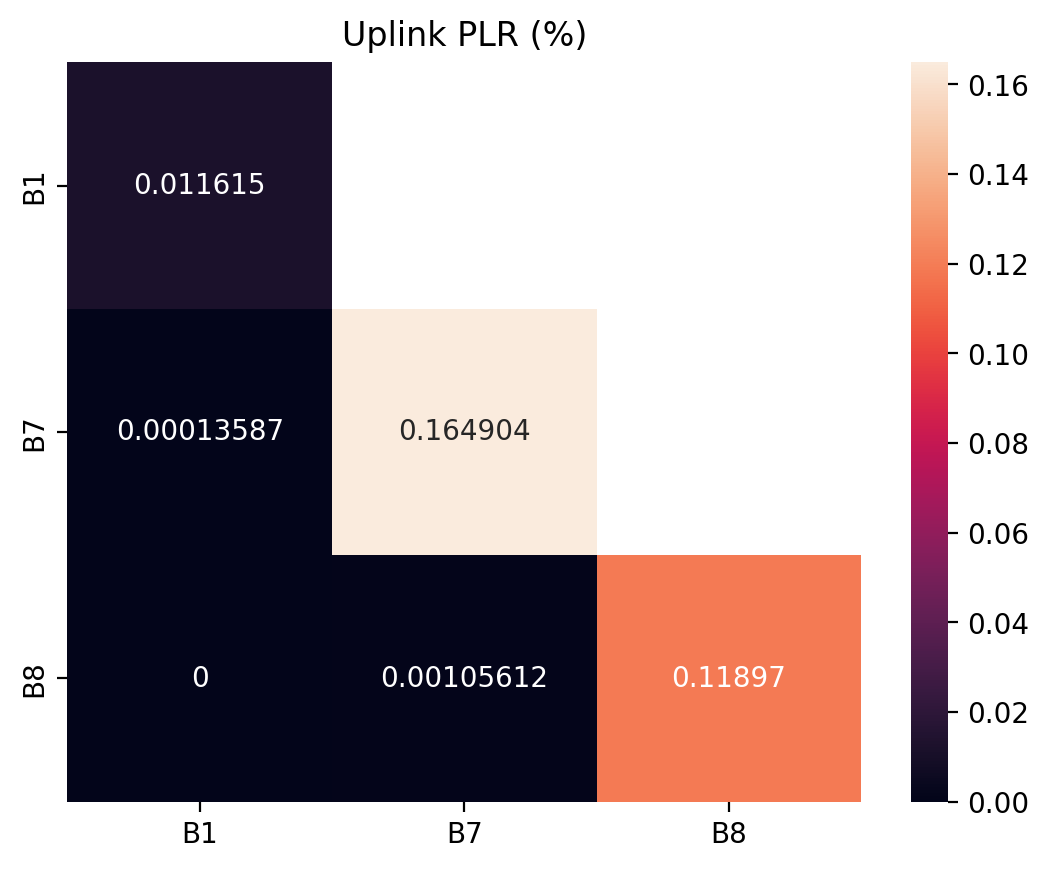

In [73]:
N = len(dfs_ul)
print(N)

table = pd.DataFrame(columns=tags)
for i in range(N):
# for i in range(5, 6):
    row = []
    for x, tag in zip(xs, tags):
        if type(x) is not tuple:
            if not dfs_ul[i][x].empty:
                df = dfs_ul[i][x].copy()
                PLR = df.lost.mean() * 100
            else:
                PLR = np.nan
        else:
            if not (dfs_ul[i][x[0]].empty or dfs_ul[i][x[1]].empty):
                df = pd.merge(dfs_ul[i][x[0]].copy(), dfs_ul[i][x[1]].copy(), on=['seq'], suffixes=('_m','_s')).copy()
                PLR = (df.lost_m & df.lost_s).mean() * 100
            else:
                PLR = np.nan
        row.append(PLR)
    table = pd.concat([table, pd.DataFrame(row, index=table.columns).T])

mat = fill_out_matrix(schemes, mtags, table.mean().to_dict())
ax = sns.heatmap(mat.T, annot=True, fmt='.6g', mask=mask(len(schemes)))
ax.set_title('Uplink PLR (%)')
plt.show()

20


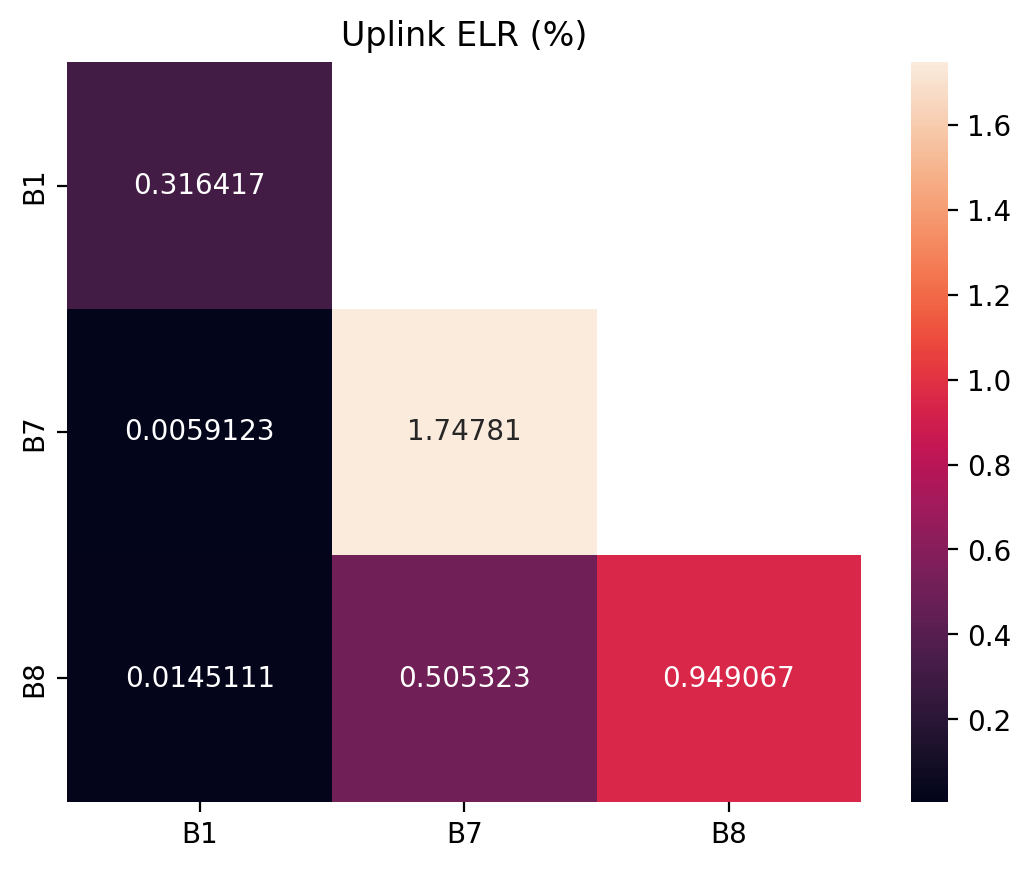

In [74]:
N = len(dfs_ul)
print(N)

table = pd.DataFrame(columns=tags)
for i in range(N):
# for i in range(5, 6):
    row = []
    for x, tag in zip(xs, tags):
        if type(x) is not tuple:
            if not dfs_ul[i][x].empty:
                df = dfs_ul[i][x].copy()
                ELR = df[~df.lost].excl.mean() * 100
            else:
                ELR = np.nan
        else:
            if not (dfs_ul[i][x[0]].empty or dfs_ul[i][x[1]].empty):
                df = pd.merge(dfs_ul[i][x[0]].copy(), dfs_ul[i][x[1]].copy(), on=['seq'], suffixes=('_m','_s')).copy()
                ELR = (df[~df.lost_m].excl_m & df[~df.lost_m].excl_s).mean() * 100
            else:
                ELR = np.nan
        row.append(ELR)
    table = pd.concat([table, pd.DataFrame(row, index=table.columns).T])

mat = fill_out_matrix(schemes, mtags, table.mean().to_dict())
ax = sns.heatmap(mat.T, annot=True, fmt='.6g', mask=mask(len(schemes)))
ax.set_title('Uplink ELR (%)')
plt.show()

20


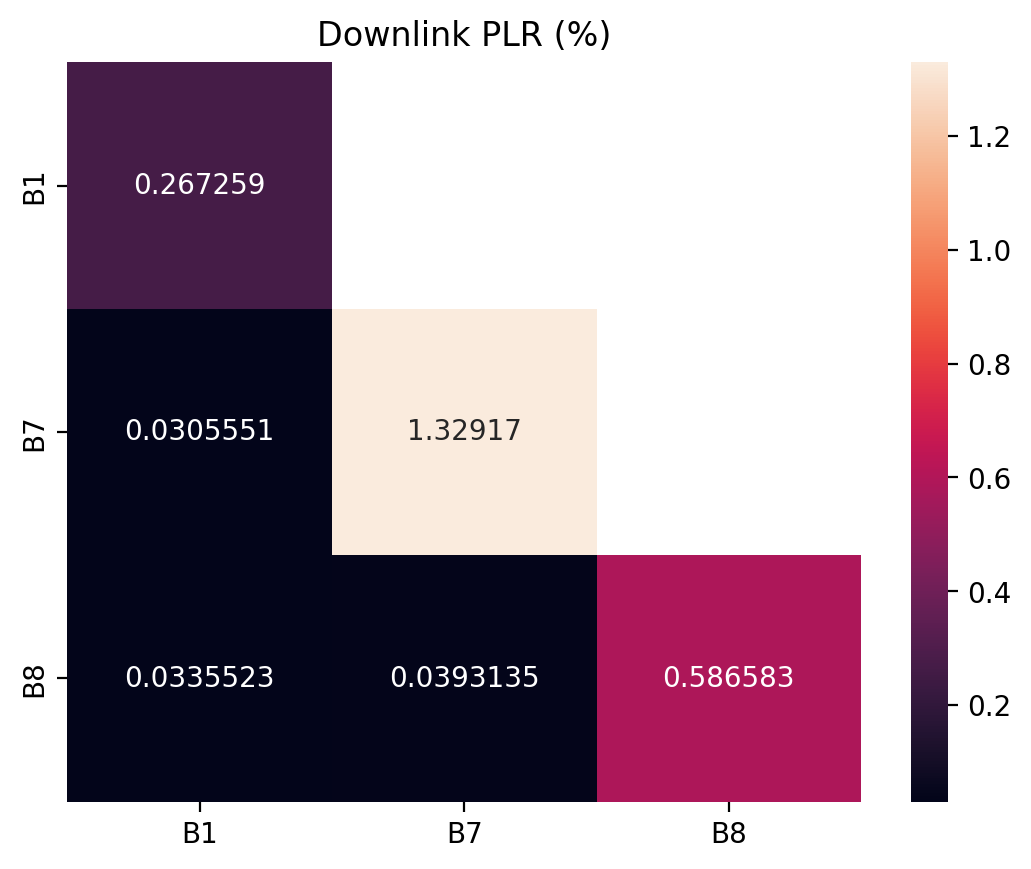

In [75]:
N = len(dfs_dl)
print(N)

table = pd.DataFrame(columns=tags)
for i in range(N):
# for i in range(5, 6):
    row = []
    for x, tag in zip(xs, tags):
        if type(x) is not tuple:
            if not dfs_dl[i][x].empty:
                df = dfs_dl[i][x].copy()
                PLR = df.lost.mean() * 100
            else:
                PLR = np.nan
        else:
            if not (dfs_dl[i][x[0]].empty or dfs_dl[i][x[1]].empty):
                df = pd.merge(dfs_dl[i][x[0]].copy(), dfs_dl[i][x[1]].copy(), on=['seq'], suffixes=('_m','_s')).copy()
                PLR = (df.lost_m & df.lost_s).mean() * 100
            else:
                PLR = np.nan
        row.append(PLR)
    table = pd.concat([table, pd.DataFrame(row, index=table.columns).T])

mat = fill_out_matrix(schemes, mtags, table.mean().to_dict())
ax = sns.heatmap(mat.T, annot=True, fmt='.6g', mask=mask(len(schemes)))
ax.set_title('Downlink PLR (%)')
plt.show()

20


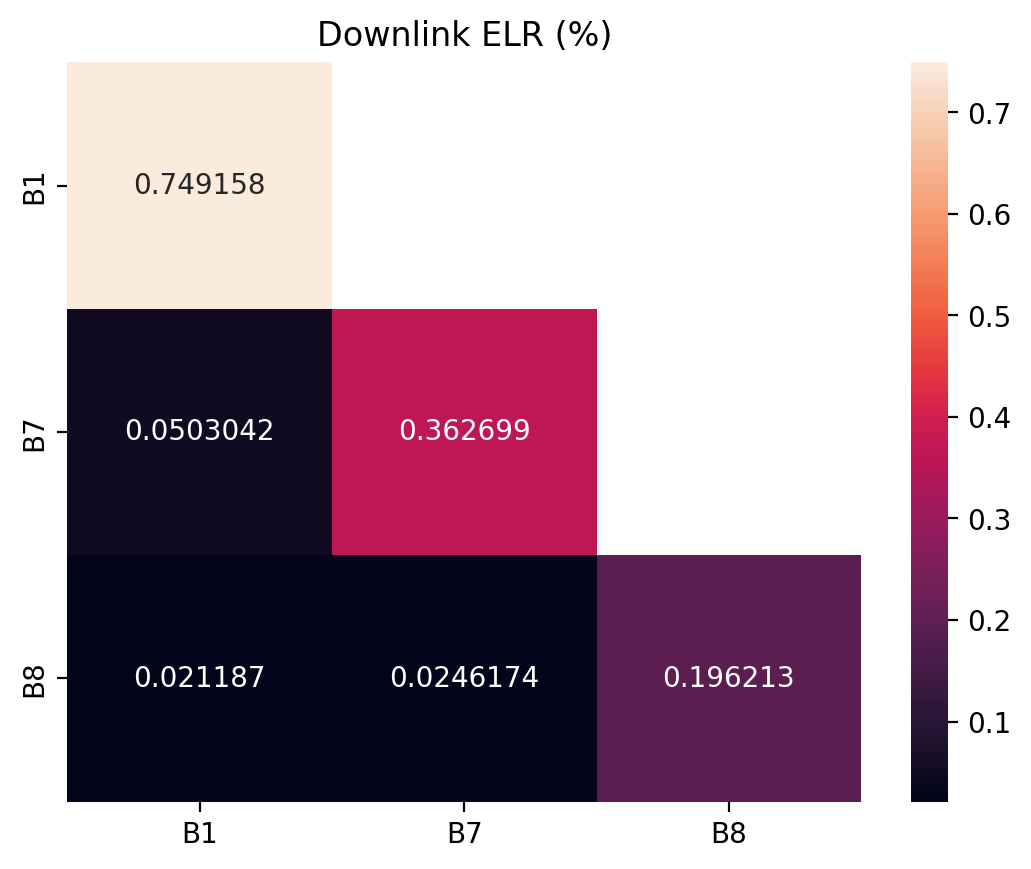

In [76]:
N = len(dfs_dl)
print(N)

table = pd.DataFrame(columns=tags)
for i in range(N):
# for i in range(5, 6):
    row = []
    for x, tag in zip(xs, tags):
        if type(x) is not tuple:
            if not dfs_dl[i][x].empty:
                df = dfs_dl[i][x].copy()
                ELR = df[~df.lost].excl.mean() * 100
            else:
                ELR = np.nan
        else:
            if not (dfs_dl[i][x[0]].empty or dfs_dl[i][x[1]].empty):
                df = pd.merge(dfs_dl[i][x[0]].copy(), dfs_dl[i][x[1]].copy(), on=['seq'], suffixes=('_m','_s')).copy()
                ELR = (df[~df.lost_m].excl_m & df[~df.lost_m].excl_s).mean() * 100
            else:
                ELR = np.nan
        row.append(ELR)
    table = pd.concat([table, pd.DataFrame(row, index=table.columns).T])

mat = fill_out_matrix(schemes, mtags, table.mean().to_dict())
ax = sns.heatmap(mat.T, annot=True, fmt='.6g', mask=mask(len(schemes)))
ax.set_title('Downlink ELR (%)')
plt.show()

## PLR_mlss, ELR_mess

In [77]:
xs = list(it.product(schemes, repeat=2))
xs = ['+'.join([s[0], s[1]]) if s[0] != s[1] else s[0] for s in xs]
xs = np.reshape(xs, (len(schemes), len(schemes)))
mtags = xs

xs = list(it.product(schemes, repeat=2))
tags = ['+'.join([s[0], s[1]]) if s[0] != s[1] else s[0] for s in xs]

xs = list(it.product(range(len(schemes)), repeat=2))
xs = [s if s[0] != s[1] else s[0] for s in xs]

print(xs)
print(tags)
display(pd.DataFrame(mtags))

[0, (0, 1), (0, 2), (1, 0), 1, (1, 2), (2, 0), (2, 1), 2]
['B1', 'B1+B7', 'B1+B8', 'B7+B1', 'B7', 'B7+B8', 'B8+B1', 'B8+B7', 'B8']


,0,1,2
0,B1,B1+B7,B1+B8
1,B7+B1,B7,B7+B8
2,B8+B1,B8+B7,B8


20


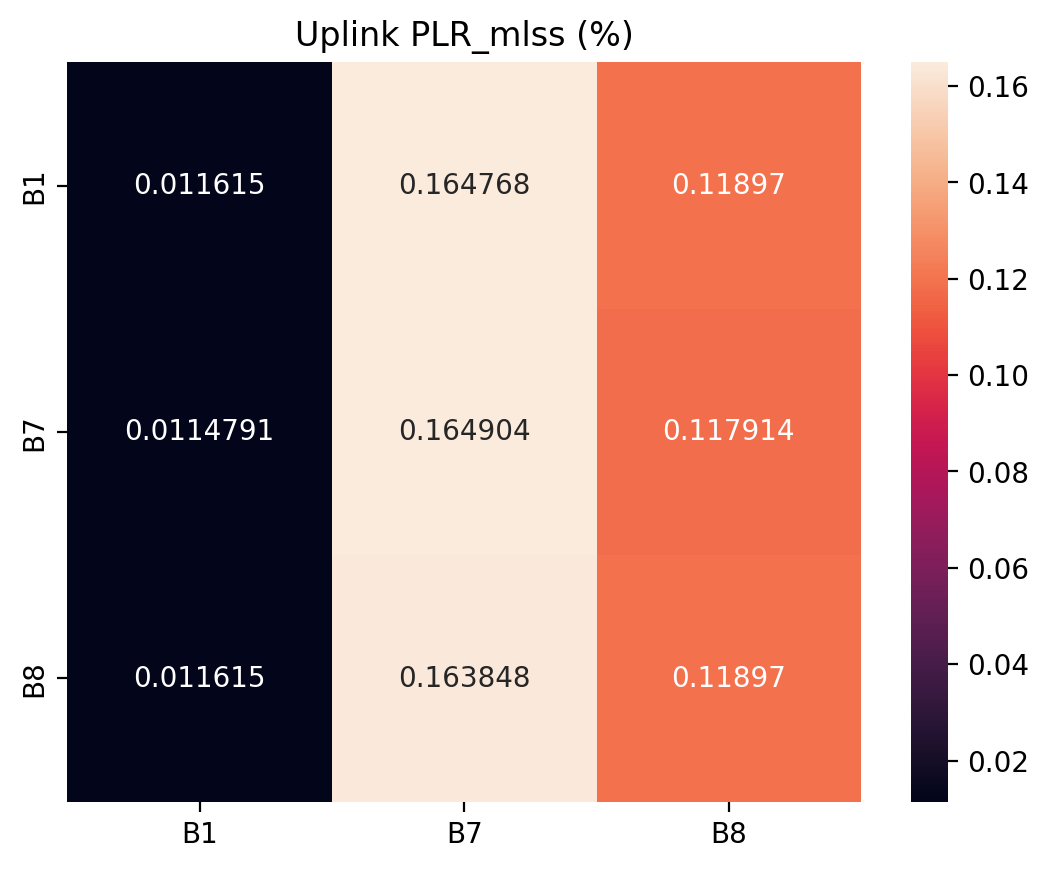

In [78]:
N = len(dfs_ul)
print(N)

table = pd.DataFrame(columns=tags)
for i in range(N):
# for i in range(5, 7):
    row = []
    for x, tag in zip(xs, tags):
        if type(x) is not tuple:
            if not dfs_ul[i][x].empty:
                df = dfs_ul[i][x].copy()
                PLR = df.lost.mean() * 100
            else:
                PLR = np.nan
        else:
            if not (dfs_ul[i][x[0]].empty or dfs_ul[i][x[1]].empty):
                df = pd.merge(dfs_ul[i][x[0]].copy(), dfs_ul[i][x[1]].copy(), on=['seq'], suffixes=('_m','_s')).copy()
                PLR = (df.lost_m & ~df.lost_s).mean() * 100
            else:
                PLR = np.nan
        row.append(PLR)
    table = pd.concat([table, pd.DataFrame(row, index=table.columns).T])

mat = fill_out_matrix(schemes, mtags, table.mean().to_dict())
ax = sns.heatmap(mat.T, annot=True, fmt='.6g')
ax.set_title('Uplink PLR_mlss (%)')
plt.show()

20


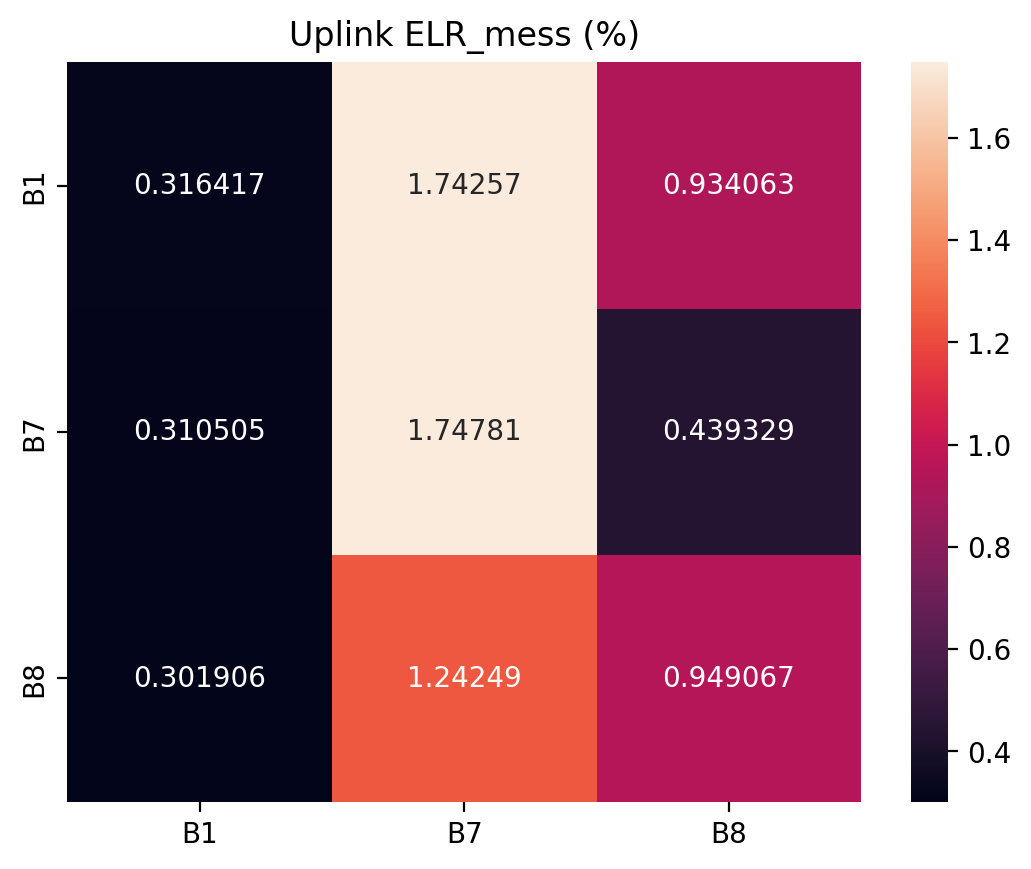

In [79]:
N = len(dfs_ul)
print(N)

table = pd.DataFrame(columns=tags)
for i in range(N):
# for i in range(5, 6):
    row = []
    for x, tag in zip(xs, tags):
        if type(x) is not tuple:
            if not dfs_ul[i][x].empty:
                df = dfs_ul[i][x].copy()
                ELR = df[~df.lost].excl.mean() * 100
            else:
                ELR = np.nan
        else:
            if not (dfs_ul[i][x[0]].empty or dfs_ul[i][x[1]].empty):
                df = pd.merge(dfs_ul[i][x[0]].copy(), dfs_ul[i][x[1]].copy(), on=['seq'], suffixes=('_m','_s')).copy()
                ELR = (df[~df.lost_m].excl_m & ~df[~df.lost_m].excl_s).mean() * 100
            else:
                ELR = np.nan
        row.append(ELR)
    table = pd.concat([table, pd.DataFrame(row, index=table.columns).T])

mat = fill_out_matrix(schemes, mtags, table.mean().to_dict())
ax = sns.heatmap(mat.T, annot=True, fmt='.6g')
ax.set_title('Uplink ELR_mess (%)')
plt.show()

20


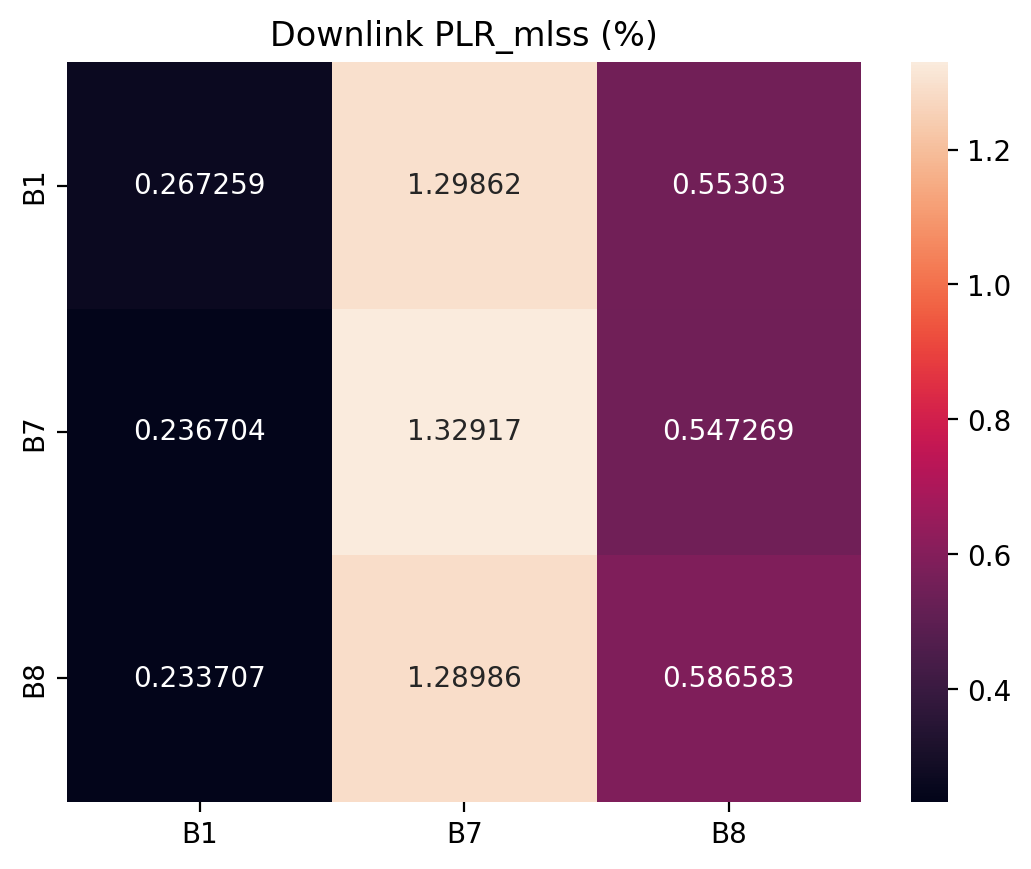

In [80]:
N = len(dfs_dl)
print(N)

table = pd.DataFrame(columns=tags)
for i in range(N):
# for i in range(5, 7):
    row = []
    for x, tag in zip(xs, tags):
        if type(x) is not tuple:
            if not dfs_dl[i][x].empty:
                df = dfs_dl[i][x].copy()
                PLR = df.lost.mean() * 100
            else:
                PLR = np.nan
        else:
            if not (dfs_dl[i][x[0]].empty or dfs_dl[i][x[1]].empty):
                df = pd.merge(dfs_dl[i][x[0]].copy(), dfs_dl[i][x[1]].copy(), on=['seq'], suffixes=('_m','_s')).copy()
                PLR = (df.lost_m & ~df.lost_s).mean() * 100
            else:
                PLR = np.nan
        row.append(PLR)
    table = pd.concat([table, pd.DataFrame(row, index=table.columns).T])

mat = fill_out_matrix(schemes, mtags, table.mean().to_dict())
ax = sns.heatmap(mat.T, annot=True, fmt='.6g')
ax.set_title('Downlink PLR_mlss (%)')
plt.show()

20


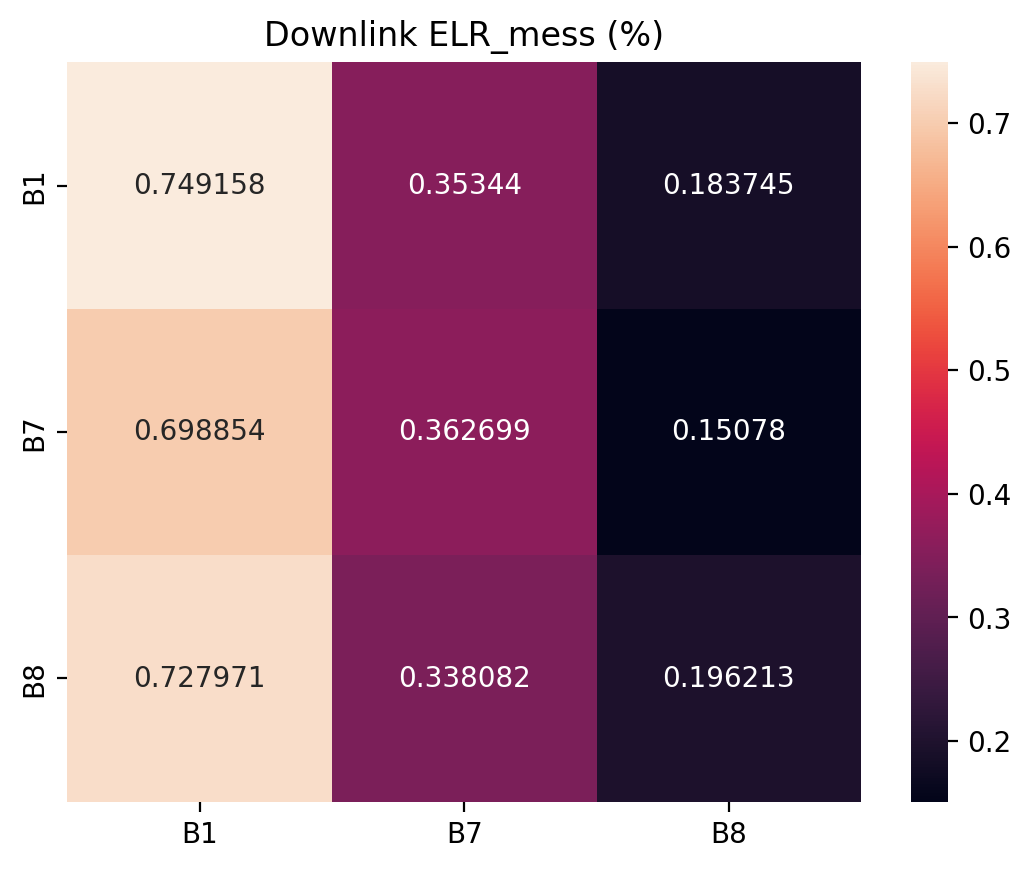

In [81]:
N = len(dfs_dl)
print(N)

table = pd.DataFrame(columns=tags)
for i in range(N):
# for i in range(5, 6):
    row = []
    for x, tag in zip(xs, tags):
        if type(x) is not tuple:
            if not dfs_dl[i][x].empty:
                df = dfs_dl[i][x].copy()
                ELR = df[~df.lost].excl.mean() * 100
            else:
                ELR = np.nan
        else:
            if not (dfs_dl[i][x[0]].empty or dfs_dl[i][x[1]].empty):
                df = pd.merge(dfs_dl[i][x[0]].copy(), dfs_dl[i][x[1]].copy(), on=['seq'], suffixes=('_m','_s')).copy()
                ELR = (df[~df.lost_m].excl_m & ~df[~df.lost_m].excl_s).mean() * 100
            else:
                ELR = np.nan
        row.append(ELR)
    table = pd.concat([table, pd.DataFrame(row, index=table.columns).T])

mat = fill_out_matrix(schemes, mtags, table.mean().to_dict())
ax = sns.heatmap(mat.T, annot=True, fmt='.6g')
ax.set_title('Downlink ELR_mess (%)')
plt.show()

# HO Count

In [82]:
def single_radio_merge(tb_list):
    table = tb_list[0].copy().set_index('ho_type0')
    for i in range(1, len(tb_list)):
        table = table.add(tb_list[i].copy().set_index('ho_type0'), fill_value=0)
    table = table.reset_index()
    return table

def dual_radio_merge(tb_list):
    table = tb_list[0].copy().set_index(['ho_type0_m','ho_type0_s','ho_type0_ms'])
    for i in range(1, len(tb_list)):
        table = table.add(tb_list[i].copy().set_index(['ho_type0_m','ho_type0_s','ho_type0_ms']), fill_value=0)
    table = table.reset_index()
    return table

sorter = ['stable',
          'LTE_HO','MN_HO','SN_HO','MNSN_HO','SN_Rel','SN_Setup','SN_Rel_MN_HO','SN_Setup_MN_HO',
          'SCG_Failure_t310-Expiry (0)','SCG_Failure_randomAccessProblem (1)','SCG_Failure_rlc-MaxNumRetx (2)','SCG_Failure_synchReconfigFailureSCG (3)',
          'SCG_Failure_scg-ReconfigFailure (4)','SCG_Failure_srb3-IntegrityFailure (5)','SCG_Failure_other-r16 (6)',
          'MCG_Failure_reconfigurationFailure (0)','MCG_Failure_handoverFailure (1)','MCG_Failure_otherFailure (2)',
          'NAS_Recovery_reconfigurationFailure (0)','NAS_Recovery_handoverFailure (1)','NAS_Recovery_otherFailure (2)']
sorter1 = list(it.product(sorter, repeat=2))
sorter1 = ['+'.join([s[0],s[1]]) for s in sorter1]

# xs = list(it.combinations(schemes, 2))
xs = list(it.permutations(schemes, 2))
tags = ['+'.join([s[0], s[1]]) for s in xs]

# xs = list(it.combinations(range(len(schemes)), 2))
xs = list(it.permutations(range(len(schemes)), 2))

print(xs)
print(tags)

[(0, 1), (0, 2), (1, 0), (1, 2), (2, 0), (2, 1)]
['B1+B7', 'B1+B8', 'B7+B1', 'B7+B8', 'B8+B1', 'B8+B7']


In [83]:
N = len(dfs_ul)

table_list = []
for i in range(N):
# for i in range(5, 8):
    table = pd.DataFrame(columns=['ul'], index=sorter) \
                         .fillna(0).reset_index().rename(columns={'index':'ho_type0'}).drop(columns=['ul'])
    flag = True
    for j, (dev, schm) in enumerate(zip(devices, schemes)):
        # print(j)
        _table = pd.DataFrame(columns=[schm], index=sorter) \
                              .fillna(0).reset_index().rename(columns={'index':'ho_type0'})
        if not dfs_ul[i][j].empty:
            df = dfs_ul[i][j].copy()
        else:
            flag = False
            break
        df['ho_type0'] = df['ho_type0'].cat.set_categories(sorter)
        tb_tmp = df.loc[:, ['ho_type0', 'ho_index']].value_counts().reset_index()
        tb_dict = tb_tmp['ho_type0'].value_counts().to_dict()
        for key, val in tb_dict.items():
            _table.loc[_table['ho_type0'] == key, schm] = val
        table = pd.concat([table, _table[schm]], axis=1)
    if flag:
        table_list.append(table)

print(len(table_list))
table_sr_ulho = single_radio_merge(table_list)

16


In [84]:
N = len(dfs_dl)

table_list = []
for i in range(N):
# for i in range(5, 8):
    table = pd.DataFrame(columns=['dl'], index=sorter) \
                         .fillna(0).reset_index().rename(columns={'index':'ho_type0'}).drop(columns=['dl'])
    flag = True
    for j, (dev, schm) in enumerate(zip(devices, schemes)):
        # print(j)
        _table = pd.DataFrame(columns=[schm], index=sorter) \
                              .fillna(0).reset_index().rename(columns={'index':'ho_type0'})
        if not dfs_dl[i][j].empty:
            df = dfs_dl[i][j].copy()
        else:
            flag = False
            break
        df['ho_type0'] = df['ho_type0'].cat.set_categories(sorter)
        tb_tmp = df.loc[:, ['ho_type0', 'ho_index']].value_counts().reset_index()
        tb_dict = tb_tmp['ho_type0'].value_counts().to_dict()
        for key, val in tb_dict.items():
            _table.loc[_table['ho_type0'] == key, schm] = val
        table = pd.concat([table, _table[schm]], axis=1)
    if flag:
        table_list.append(table)

print(len(table_list))
table_sr_dlho = single_radio_merge(table_list)

16


In [85]:
N = len(dfs_ul)

table_list = []
for i in range(N):
# for i in range(5, 8):
    table = pd.DataFrame(columns=['ul'],
                         index=[sorter2, sorter3, sorter1]).fillna(0).reset_index() \
                        .rename(columns={'level_0':'ho_type0_m', 'level_1':'ho_type0_s', 'level_2':'ho_type0_ms'}) \
                        .drop(columns=['ul'])
    flag = True
    for x, tag in zip(xs, tags):
        # print(x)
        _table = pd.DataFrame(columns=[tag],
                             index=[sorter2, sorter3, sorter1]).fillna(0).reset_index() \
                            .rename(columns={'level_0':'ho_type0_m', 'level_1':'ho_type0_s', 'level_2':'ho_type0_ms'})
        if not (dfs_ul[i][x[0]].empty or dfs_ul[i][x[1]].empty):
            df = pd.merge(dfs_ul[i][x[0]].copy(), dfs_ul[i][x[1]].copy(), on=['seq'], suffixes=('_m','_s')).copy()
        else:
            flag = False
            break
        df['ho_type0_ms'] = df['ho_type0_m'].astype('string') + '+' + df['ho_type0_s'].astype('string')
        df['ho_type0_ms'] = df['ho_type0_ms'].astype('category')
        df['ho_type0_ms'] = df['ho_type0_ms'].cat.set_categories(sorter1)
        tb_tmp = df.loc[:, ['ho_type0_ms','ho_index_m','ho_index_s']].value_counts().reset_index()
        tb_dict = tb_tmp['ho_type0_ms'].value_counts().to_dict()
        for key, val in tb_dict.items():
            _table.loc[_table['ho_type0_ms'] == key, tag] = val
        table = pd.concat([table, _table[tag]], axis=1)
    if flag:
        table_list.append(table)

print(len(table_list))
table_dr_ulho = dual_radio_merge(table_list)

16


In [86]:
N = len(dfs_dl)

table_list = []
for i in range(N):
# for i in range(5, 8):
    table = pd.DataFrame(columns=['dl'],
                         index=[sorter2, sorter3, sorter1]).fillna(0).reset_index() \
                        .rename(columns={'level_0':'ho_type0_m', 'level_1':'ho_type0_s', 'level_2':'ho_type0_ms'}) \
                        .drop(columns=['dl'])
    flag = True
    for x, tag in zip(xs, tags):
        # print(x)
        _table = pd.DataFrame(columns=[tag],
                             index=[sorter2, sorter3, sorter1]).fillna(0).reset_index() \
                            .rename(columns={'level_0':'ho_type0_m', 'level_1':'ho_type0_s', 'level_2':'ho_type0_ms'})
        if not (dfs_dl[i][x[0]].empty or dfs_dl[i][x[1]].empty):
            df = pd.merge(dfs_dl[i][x[0]].copy(), dfs_dl[i][x[1]].copy(), on=['seq'], suffixes=('_m','_s')).copy()
        else:
            flag = False
            break
        df['ho_type0_ms'] = df['ho_type0_m'].astype('string') + '+' + df['ho_type0_s'].astype('string')
        df['ho_type0_ms'] = df['ho_type0_ms'].astype('category')
        df['ho_type0_ms'] = df['ho_type0_ms'].cat.set_categories(sorter1)
        tb_tmp = df.loc[:, ['ho_type0_ms','ho_index_m','ho_index_s']].value_counts().reset_index()
        tb_dict = tb_tmp['ho_type0_ms'].value_counts().to_dict()
        for key, val in tb_dict.items():
            _table.loc[_table['ho_type0_ms'] == key, tag] = val
        table = pd.concat([table, _table[tag]], axis=1)
    if flag:
        table_list.append(table)

print(len(table_list))
table_dr_dlho = dual_radio_merge(table_list)

16


In [87]:
table_sr_ulho = table_sr_ulho.query('B1 > 0 | B7 > 0 | B8 > 0').tail(-1).reset_index(drop=True)
table_sr_dlho = table_sr_dlho.query('B1 > 0 | B7 > 0 | B8 > 0').tail(-1).reset_index(drop=True)
table_dr_ulho = table_dr_ulho[(table_dr_ulho['B1+B7'] > 0) | (table_dr_ulho['B1+B8'] > 0) | (table_dr_ulho['B7+B1'] > 0)| (table_dr_ulho['B7+B8'] > 0) | (table_dr_ulho['B8+B1'] > 0) | (table_dr_ulho['B8+B7'] > 0)].tail(-1).reset_index(drop=True)
table_dr_dlho = table_dr_dlho[(table_dr_dlho['B1+B7'] > 0) | (table_dr_dlho['B1+B8'] > 0) | (table_dr_dlho['B7+B1'] > 0)| (table_dr_dlho['B7+B8'] > 0) | (table_dr_dlho['B8+B1'] > 0) | (table_dr_dlho['B8+B7'] > 0)].tail(-1).reset_index(drop=True)

## Results

In [88]:
with pd.option_context('display.max_rows', None):
    display(table_sr_ulho.sort_values('B1', ascending=False))
    display(table_dr_ulho[table_dr_ulho['B1+B7'] > 0].sort_values('B1+B7', ascending=False).reset_index(drop=True))
    display(table_sr_dlho.sort_values('B1', ascending=False))
    display(table_dr_dlho[table_dr_dlho['B1+B7'] > 0].sort_values('B1+B7', ascending=False).reset_index(drop=True))

,ho_type0,B1,B7,B8
0,LTE_HO,228,55,34
8,MCG_Failure_otherFailure (2),8,58,12
7,MCG_Failure_handoverFailure (1),4,2,0
1,MN_HO,0,247,289
2,SN_HO,0,239,276
3,SN_Rel,0,5,4
4,SN_Setup,0,100,45
5,SCG_Failure_t310-Expiry (0),0,1,1
6,SCG_Failure_synchReconfigFailureSCG (3),0,3,3
9,NAS_Recovery_otherFailure (2),0,0,1


,ho_type0_m,ho_type0_s,ho_type0_ms,B1+B7,B1+B8,B7+B1,B7+B8,B8+B1,B8+B7
0,stable,MN_HO,stable+MN_HO,226,259,0,215,0,199
1,stable,SN_HO,stable+SN_HO,213,239,0,198,0,172
2,LTE_HO,stable,LTE_HO+stable,159,146,39,31,22,16
3,LTE_HO,MN_HO,LTE_HO+MN_HO,101,146,0,19,0,10
4,LTE_HO,SN_HO,LTE_HO+SN_HO,95,139,0,20,0,15
5,stable,SN_Setup,stable+SN_Setup,71,39,0,29,0,46
6,stable,MCG_Failure_otherFailure (2),stable+MCG_Failure_otherFailure (2),53,9,7,10,8,45
7,LTE_HO,SN_Setup,LTE_HO+SN_Setup,51,21,0,2,0,5
8,LTE_HO,MCG_Failure_otherFailure (2),LTE_HO+MCG_Failure_otherFailure (2),49,16,1,1,0,6
9,stable,LTE_HO,stable+LTE_HO,39,22,159,16,146,31


,ho_type0,B1,B7,B8
0,LTE_HO,235,59,30
8,MCG_Failure_otherFailure (2),10,53,13
7,MCG_Failure_handoverFailure (1),5,1,0
1,MN_HO,0,233,297
2,SN_HO,0,238,278
3,SN_Rel,0,4,1
4,SN_Setup,0,99,38
5,SCG_Failure_t310-Expiry (0),0,1,1
6,SCG_Failure_synchReconfigFailureSCG (3),0,2,1
9,NAS_Recovery_otherFailure (2),0,0,1


,ho_type0_m,ho_type0_s,ho_type0_ms,B1+B7,B1+B8,B7+B1,B7+B8,B8+B1,B8+B7
0,stable,MN_HO,stable+MN_HO,214,257,0,216,0,186
1,stable,SN_HO,stable+SN_HO,213,244,0,209,0,184
2,LTE_HO,stable,LTE_HO+stable,169,149,41,36,19,18
3,LTE_HO,MN_HO,LTE_HO+MN_HO,98,157,0,23,0,7
4,LTE_HO,SN_HO,LTE_HO+SN_HO,91,137,0,20,0,14
5,stable,SN_Setup,stable+SN_Setup,62,32,0,27,0,39
6,LTE_HO,SN_Setup,LTE_HO+SN_Setup,57,18,0,2,0,5
7,LTE_HO,MCG_Failure_otherFailure (2),LTE_HO+MCG_Failure_otherFailure (2),52,16,1,1,1,4
8,stable,MCG_Failure_otherFailure (2),stable+MCG_Failure_otherFailure (2),49,9,9,11,9,41
9,stable,LTE_HO,stable+LTE_HO,41,19,169,18,149,36


In [89]:
with pd.option_context('display.max_rows', None):
    display(table_sr_ulho.sort_values('B1', ascending=False))
    display(table_dr_ulho[table_dr_ulho['B1+B8'] > 0].sort_values('B1+B8', ascending=False).reset_index(drop=True))
    display(table_sr_dlho.sort_values('B1', ascending=False))
    display(table_dr_dlho[table_dr_dlho['B1+B8'] > 0].sort_values('B1+B8', ascending=False).reset_index(drop=True))

,ho_type0,B1,B7,B8
0,LTE_HO,228,55,34
8,MCG_Failure_otherFailure (2),8,58,12
7,MCG_Failure_handoverFailure (1),4,2,0
1,MN_HO,0,247,289
2,SN_HO,0,239,276
3,SN_Rel,0,5,4
4,SN_Setup,0,100,45
5,SCG_Failure_t310-Expiry (0),0,1,1
6,SCG_Failure_synchReconfigFailureSCG (3),0,3,3
9,NAS_Recovery_otherFailure (2),0,0,1


,ho_type0_m,ho_type0_s,ho_type0_ms,B1+B7,B1+B8,B7+B1,B7+B8,B8+B1,B8+B7
0,stable,MN_HO,stable+MN_HO,226,259,0,215,0,199
1,stable,SN_HO,stable+SN_HO,213,239,0,198,0,172
2,LTE_HO,MN_HO,LTE_HO+MN_HO,101,146,0,19,0,10
3,LTE_HO,stable,LTE_HO+stable,159,146,39,31,22,16
4,LTE_HO,SN_HO,LTE_HO+SN_HO,95,139,0,20,0,15
5,stable,SN_Setup,stable+SN_Setup,71,39,0,29,0,46
6,stable,LTE_HO,stable+LTE_HO,39,22,159,16,146,31
7,LTE_HO,SN_Setup,LTE_HO+SN_Setup,51,21,0,2,0,5
8,LTE_HO,LTE_HO,LTE_HO+LTE_HO,24,16,24,0,16,0
9,LTE_HO,MCG_Failure_otherFailure (2),LTE_HO+MCG_Failure_otherFailure (2),49,16,1,1,0,6


,ho_type0,B1,B7,B8
0,LTE_HO,235,59,30
8,MCG_Failure_otherFailure (2),10,53,13
7,MCG_Failure_handoverFailure (1),5,1,0
1,MN_HO,0,233,297
2,SN_HO,0,238,278
3,SN_Rel,0,4,1
4,SN_Setup,0,99,38
5,SCG_Failure_t310-Expiry (0),0,1,1
6,SCG_Failure_synchReconfigFailureSCG (3),0,2,1
9,NAS_Recovery_otherFailure (2),0,0,1


,ho_type0_m,ho_type0_s,ho_type0_ms,B1+B7,B1+B8,B7+B1,B7+B8,B8+B1,B8+B7
0,stable,MN_HO,stable+MN_HO,214,257,0,216,0,186
1,stable,SN_HO,stable+SN_HO,213,244,0,209,0,184
2,LTE_HO,MN_HO,LTE_HO+MN_HO,98,157,0,23,0,7
3,LTE_HO,stable,LTE_HO+stable,169,149,41,36,19,18
4,LTE_HO,SN_HO,LTE_HO+SN_HO,91,137,0,20,0,14
5,stable,SN_Setup,stable+SN_Setup,62,32,0,27,0,39
6,stable,LTE_HO,stable+LTE_HO,41,19,169,18,149,36
7,LTE_HO,SN_Setup,LTE_HO+SN_Setup,57,18,0,2,0,5
8,LTE_HO,MCG_Failure_otherFailure (2),LTE_HO+MCG_Failure_otherFailure (2),52,16,1,1,1,4
9,LTE_HO,LTE_HO,LTE_HO+LTE_HO,29,14,29,0,14,0


In [90]:
with pd.option_context('display.max_rows', None):
    display(table_sr_ulho.sort_values('B7', ascending=False))
    display(table_dr_ulho[table_dr_ulho['B7+B1'] > 0].sort_values('B7+B1', ascending=False).reset_index(drop=True))
    display(table_sr_dlho.sort_values('B7', ascending=False))
    display(table_dr_dlho[table_dr_dlho['B7+B1'] > 0].sort_values('B7+B1', ascending=False).reset_index(drop=True))

,ho_type0,B1,B7,B8
1,MN_HO,0,247,289
2,SN_HO,0,239,276
4,SN_Setup,0,100,45
8,MCG_Failure_otherFailure (2),8,58,12
0,LTE_HO,228,55,34
3,SN_Rel,0,5,4
6,SCG_Failure_synchReconfigFailureSCG (3),0,3,3
7,MCG_Failure_handoverFailure (1),4,2,0
5,SCG_Failure_t310-Expiry (0),0,1,1
9,NAS_Recovery_otherFailure (2),0,0,1


,ho_type0_m,ho_type0_s,ho_type0_ms,B1+B7,B1+B8,B7+B1,B7+B8,B8+B1,B8+B7
0,MN_HO,stable,MN_HO+stable,0,0,226,199,259,215
1,SN_HO,stable,SN_HO+stable,0,0,213,172,239,198
2,stable,LTE_HO,stable+LTE_HO,39,22,159,16,146,31
3,MN_HO,LTE_HO,MN_HO+LTE_HO,0,0,101,10,146,19
4,SN_HO,LTE_HO,SN_HO+LTE_HO,0,0,95,15,139,20
5,SN_Setup,stable,SN_Setup+stable,0,0,71,46,39,29
6,MCG_Failure_otherFailure (2),stable,MCG_Failure_otherFailure (2)+stable,7,8,53,45,9,10
7,SN_Setup,LTE_HO,SN_Setup+LTE_HO,0,0,51,5,21,2
8,MCG_Failure_otherFailure (2),LTE_HO,MCG_Failure_otherFailure (2)+LTE_HO,1,0,49,6,16,1
9,LTE_HO,stable,LTE_HO+stable,159,146,39,31,22,16


,ho_type0,B1,B7,B8
2,SN_HO,0,238,278
1,MN_HO,0,233,297
4,SN_Setup,0,99,38
0,LTE_HO,235,59,30
8,MCG_Failure_otherFailure (2),10,53,13
3,SN_Rel,0,4,1
6,SCG_Failure_synchReconfigFailureSCG (3),0,2,1
5,SCG_Failure_t310-Expiry (0),0,1,1
7,MCG_Failure_handoverFailure (1),5,1,0
9,NAS_Recovery_otherFailure (2),0,0,1


,ho_type0_m,ho_type0_s,ho_type0_ms,B1+B7,B1+B8,B7+B1,B7+B8,B8+B1,B8+B7
0,MN_HO,stable,MN_HO+stable,0,0,214,186,257,216
1,SN_HO,stable,SN_HO+stable,0,0,213,184,244,209
2,stable,LTE_HO,stable+LTE_HO,41,19,169,18,149,36
3,MN_HO,LTE_HO,MN_HO+LTE_HO,0,0,98,7,157,23
4,SN_HO,LTE_HO,SN_HO+LTE_HO,0,0,91,14,137,20
5,SN_Setup,stable,SN_Setup+stable,0,0,62,39,32,27
6,SN_Setup,LTE_HO,SN_Setup+LTE_HO,0,0,57,5,18,2
7,MCG_Failure_otherFailure (2),LTE_HO,MCG_Failure_otherFailure (2)+LTE_HO,1,1,52,4,16,1
8,MCG_Failure_otherFailure (2),stable,MCG_Failure_otherFailure (2)+stable,9,9,49,41,9,11
9,LTE_HO,stable,LTE_HO+stable,169,149,41,36,19,18


In [91]:
with pd.option_context('display.max_rows', None):
    display(table_sr_ulho.sort_values('B7', ascending=False))
    display(table_dr_ulho[table_dr_ulho['B7+B8'] > 0].sort_values('B7+B8', ascending=False).reset_index(drop=True).reset_index(drop=True))
    display(table_sr_dlho.sort_values('B7', ascending=False))
    display(table_dr_dlho[table_dr_dlho['B7+B8'] > 0].sort_values('B7+B8', ascending=False).reset_index(drop=True).reset_index(drop=True))

,ho_type0,B1,B7,B8
1,MN_HO,0,247,289
2,SN_HO,0,239,276
4,SN_Setup,0,100,45
8,MCG_Failure_otherFailure (2),8,58,12
0,LTE_HO,228,55,34
3,SN_Rel,0,5,4
6,SCG_Failure_synchReconfigFailureSCG (3),0,3,3
7,MCG_Failure_handoverFailure (1),4,2,0
5,SCG_Failure_t310-Expiry (0),0,1,1
9,NAS_Recovery_otherFailure (2),0,0,1


,ho_type0_m,ho_type0_s,ho_type0_ms,B1+B7,B1+B8,B7+B1,B7+B8,B8+B1,B8+B7
0,stable,MN_HO,stable+MN_HO,226,259,0,215,0,199
1,MN_HO,stable,MN_HO+stable,0,0,226,199,259,215
2,stable,SN_HO,stable+SN_HO,213,239,0,198,0,172
3,SN_HO,stable,SN_HO+stable,0,0,213,172,239,198
4,SN_HO,SN_HO,SN_HO+SN_HO,0,0,0,146,0,146
5,SN_HO,MN_HO,SN_HO+MN_HO,0,0,0,107,0,71
6,MN_HO,MN_HO,MN_HO+MN_HO,0,0,0,79,0,79
7,MN_HO,SN_HO,MN_HO+SN_HO,0,0,0,71,0,107
8,SN_Setup,SN_HO,SN_Setup+SN_HO,0,0,0,55,0,12
9,SN_Setup,stable,SN_Setup+stable,0,0,71,46,39,29


,ho_type0,B1,B7,B8
2,SN_HO,0,238,278
1,MN_HO,0,233,297
4,SN_Setup,0,99,38
0,LTE_HO,235,59,30
8,MCG_Failure_otherFailure (2),10,53,13
3,SN_Rel,0,4,1
6,SCG_Failure_synchReconfigFailureSCG (3),0,2,1
5,SCG_Failure_t310-Expiry (0),0,1,1
7,MCG_Failure_handoverFailure (1),5,1,0
9,NAS_Recovery_otherFailure (2),0,0,1


,ho_type0_m,ho_type0_s,ho_type0_ms,B1+B7,B1+B8,B7+B1,B7+B8,B8+B1,B8+B7
0,stable,MN_HO,stable+MN_HO,214,257,0,216,0,186
1,stable,SN_HO,stable+SN_HO,213,244,0,209,0,184
2,MN_HO,stable,MN_HO+stable,0,0,214,186,257,216
3,SN_HO,stable,SN_HO+stable,0,0,213,184,244,209
4,SN_HO,SN_HO,SN_HO+SN_HO,0,0,0,127,0,127
5,SN_HO,MN_HO,SN_HO+MN_HO,0,0,0,108,0,53
6,MN_HO,MN_HO,MN_HO+MN_HO,0,0,0,81,0,81
7,SN_Setup,SN_HO,SN_Setup+SN_HO,0,0,0,62,0,11
8,MN_HO,SN_HO,MN_HO+SN_HO,0,0,0,53,0,108
9,MCG_Failure_otherFailure (2),stable,MCG_Failure_otherFailure (2)+stable,9,9,49,41,9,11


In [92]:
with pd.option_context('display.max_rows', None):
    display(table_sr_ulho.sort_values('B8', ascending=False))
    display(table_dr_ulho[table_dr_ulho['B8+B1'] > 0].sort_values('B8+B1', ascending=False).reset_index(drop=True))
    display(table_sr_dlho.sort_values('B8', ascending=False))
    display(table_dr_dlho[table_dr_dlho['B8+B1'] > 0].sort_values('B8+B1', ascending=False).reset_index(drop=True))

,ho_type0,B1,B7,B8
1,MN_HO,0,247,289
2,SN_HO,0,239,276
4,SN_Setup,0,100,45
0,LTE_HO,228,55,34
8,MCG_Failure_otherFailure (2),8,58,12
3,SN_Rel,0,5,4
6,SCG_Failure_synchReconfigFailureSCG (3),0,3,3
5,SCG_Failure_t310-Expiry (0),0,1,1
9,NAS_Recovery_otherFailure (2),0,0,1
7,MCG_Failure_handoverFailure (1),4,2,0


,ho_type0_m,ho_type0_s,ho_type0_ms,B1+B7,B1+B8,B7+B1,B7+B8,B8+B1,B8+B7
0,MN_HO,stable,MN_HO+stable,0,0,226,199,259,215
1,SN_HO,stable,SN_HO+stable,0,0,213,172,239,198
2,stable,LTE_HO,stable+LTE_HO,39,22,159,16,146,31
3,MN_HO,LTE_HO,MN_HO+LTE_HO,0,0,101,10,146,19
4,SN_HO,LTE_HO,SN_HO+LTE_HO,0,0,95,15,139,20
5,SN_Setup,stable,SN_Setup+stable,0,0,71,46,39,29
6,LTE_HO,stable,LTE_HO+stable,159,146,39,31,22,16
7,SN_Setup,LTE_HO,SN_Setup+LTE_HO,0,0,51,5,21,2
8,LTE_HO,LTE_HO,LTE_HO+LTE_HO,24,16,24,0,16,0
9,MCG_Failure_otherFailure (2),LTE_HO,MCG_Failure_otherFailure (2)+LTE_HO,1,0,49,6,16,1


,ho_type0,B1,B7,B8
1,MN_HO,0,233,297
2,SN_HO,0,238,278
4,SN_Setup,0,99,38
0,LTE_HO,235,59,30
8,MCG_Failure_otherFailure (2),10,53,13
3,SN_Rel,0,4,1
5,SCG_Failure_t310-Expiry (0),0,1,1
6,SCG_Failure_synchReconfigFailureSCG (3),0,2,1
9,NAS_Recovery_otherFailure (2),0,0,1
7,MCG_Failure_handoverFailure (1),5,1,0


,ho_type0_m,ho_type0_s,ho_type0_ms,B1+B7,B1+B8,B7+B1,B7+B8,B8+B1,B8+B7
0,MN_HO,stable,MN_HO+stable,0,0,214,186,257,216
1,SN_HO,stable,SN_HO+stable,0,0,213,184,244,209
2,MN_HO,LTE_HO,MN_HO+LTE_HO,0,0,98,7,157,23
3,stable,LTE_HO,stable+LTE_HO,41,19,169,18,149,36
4,SN_HO,LTE_HO,SN_HO+LTE_HO,0,0,91,14,137,20
5,SN_Setup,stable,SN_Setup+stable,0,0,62,39,32,27
6,LTE_HO,stable,LTE_HO+stable,169,149,41,36,19,18
7,SN_Setup,LTE_HO,SN_Setup+LTE_HO,0,0,57,5,18,2
8,MCG_Failure_otherFailure (2),LTE_HO,MCG_Failure_otherFailure (2)+LTE_HO,1,1,52,4,16,1
9,LTE_HO,LTE_HO,LTE_HO+LTE_HO,29,14,29,0,14,0


In [93]:
with pd.option_context('display.max_rows', None):
    display(table_sr_ulho.sort_values('B8', ascending=False))
    display(table_dr_ulho[table_dr_ulho['B8+B7'] > 0].sort_values('B8+B7', ascending=False).reset_index(drop=True))
    display(table_sr_dlho.sort_values('B8', ascending=False))
    display(table_dr_dlho[table_dr_dlho['B8+B7'] > 0].sort_values('B8+B7', ascending=False).reset_index(drop=True))

,ho_type0,B1,B7,B8
1,MN_HO,0,247,289
2,SN_HO,0,239,276
4,SN_Setup,0,100,45
0,LTE_HO,228,55,34
8,MCG_Failure_otherFailure (2),8,58,12
3,SN_Rel,0,5,4
6,SCG_Failure_synchReconfigFailureSCG (3),0,3,3
5,SCG_Failure_t310-Expiry (0),0,1,1
9,NAS_Recovery_otherFailure (2),0,0,1
7,MCG_Failure_handoverFailure (1),4,2,0


,ho_type0_m,ho_type0_s,ho_type0_ms,B1+B7,B1+B8,B7+B1,B7+B8,B8+B1,B8+B7
0,MN_HO,stable,MN_HO+stable,0,0,226,199,259,215
1,stable,MN_HO,stable+MN_HO,226,259,0,215,0,199
2,SN_HO,stable,SN_HO+stable,0,0,213,172,239,198
3,stable,SN_HO,stable+SN_HO,213,239,0,198,0,172
4,SN_HO,SN_HO,SN_HO+SN_HO,0,0,0,146,0,146
5,MN_HO,SN_HO,MN_HO+SN_HO,0,0,0,71,0,107
6,MN_HO,MN_HO,MN_HO+MN_HO,0,0,0,79,0,79
7,SN_HO,MN_HO,SN_HO+MN_HO,0,0,0,107,0,71
8,SN_HO,SN_Setup,SN_HO+SN_Setup,0,0,0,12,0,55
9,stable,SN_Setup,stable+SN_Setup,71,39,0,29,0,46


,ho_type0,B1,B7,B8
1,MN_HO,0,233,297
2,SN_HO,0,238,278
4,SN_Setup,0,99,38
0,LTE_HO,235,59,30
8,MCG_Failure_otherFailure (2),10,53,13
3,SN_Rel,0,4,1
5,SCG_Failure_t310-Expiry (0),0,1,1
6,SCG_Failure_synchReconfigFailureSCG (3),0,2,1
9,NAS_Recovery_otherFailure (2),0,0,1
7,MCG_Failure_handoverFailure (1),5,1,0


,ho_type0_m,ho_type0_s,ho_type0_ms,B1+B7,B1+B8,B7+B1,B7+B8,B8+B1,B8+B7
0,MN_HO,stable,MN_HO+stable,0,0,214,186,257,216
1,SN_HO,stable,SN_HO+stable,0,0,213,184,244,209
2,stable,MN_HO,stable+MN_HO,214,257,0,216,0,186
3,stable,SN_HO,stable+SN_HO,213,244,0,209,0,184
4,SN_HO,SN_HO,SN_HO+SN_HO,0,0,0,127,0,127
5,MN_HO,SN_HO,MN_HO+SN_HO,0,0,0,53,0,108
6,MN_HO,MN_HO,MN_HO+MN_HO,0,0,0,81,0,81
7,SN_HO,SN_Setup,SN_HO+SN_Setup,0,0,0,11,0,62
8,SN_HO,MN_HO,SN_HO+MN_HO,0,0,0,108,0,53
9,stable,MCG_Failure_otherFailure (2),stable+MCG_Failure_otherFailure (2),49,9,9,11,9,41


## Insight

In [94]:
with pd.option_context('display.max_rows', None):
    display(table_sr_ulho.sort_values('B1', ascending=False)[['ho_type0','B1']].reset_index(drop=True))
    display(table_sr_ulho.sort_values('B7', ascending=False)[['ho_type0','B7']].reset_index(drop=True))
    display(table_sr_ulho.sort_values('B8', ascending=False)[['ho_type0','B8']].reset_index(drop=True))
    # display(table_dr_ulho[table_dr_ulho['B1+B7'] > 0].sort_values('B1+B7', ascending=False).reset_index(drop=True))
    # display(table_sr_dlho.sort_values('B1', ascending=False))
    # display(table_dr_dlho[table_dr_dlho['B1+B7'] > 0].sort_values('B1+B7', ascending=False).reset_index(drop=True))

,ho_type0,B1
0,LTE_HO,228
1,MCG_Failure_otherFailure (2),8
2,MCG_Failure_handoverFailure (1),4
3,MN_HO,0
4,SN_HO,0
5,SN_Rel,0
6,SN_Setup,0
7,SCG_Failure_t310-Expiry (0),0
8,SCG_Failure_synchReconfigFailureSCG (3),0
9,NAS_Recovery_otherFailure (2),0


,ho_type0,B7
0,MN_HO,247
1,SN_HO,239
2,SN_Setup,100
3,MCG_Failure_otherFailure (2),58
4,LTE_HO,55
5,SN_Rel,5
6,SCG_Failure_synchReconfigFailureSCG (3),3
7,MCG_Failure_handoverFailure (1),2
8,SCG_Failure_t310-Expiry (0),1
9,NAS_Recovery_otherFailure (2),0


,ho_type0,B8
0,MN_HO,289
1,SN_HO,276
2,SN_Setup,45
3,LTE_HO,34
4,MCG_Failure_otherFailure (2),12
5,SN_Rel,4
6,SCG_Failure_synchReconfigFailureSCG (3),3
7,SCG_Failure_t310-Expiry (0),1
8,NAS_Recovery_otherFailure (2),1
9,MCG_Failure_handoverFailure (1),0


In [95]:
with pd.option_context('display.max_rows', None):
    display(table_sr_dlho.sort_values('B1', ascending=False)[['ho_type0','B1']].reset_index(drop=True))
    display(table_sr_dlho.sort_values('B7', ascending=False)[['ho_type0','B7']].reset_index(drop=True))
    display(table_sr_dlho.sort_values('B8', ascending=False)[['ho_type0','B8']].reset_index(drop=True))

,ho_type0,B1
0,LTE_HO,235
1,MCG_Failure_otherFailure (2),10
2,MCG_Failure_handoverFailure (1),5
3,MN_HO,0
4,SN_HO,0
5,SN_Rel,0
6,SN_Setup,0
7,SCG_Failure_t310-Expiry (0),0
8,SCG_Failure_synchReconfigFailureSCG (3),0
9,NAS_Recovery_otherFailure (2),0


,ho_type0,B7
0,SN_HO,238
1,MN_HO,233
2,SN_Setup,99
3,LTE_HO,59
4,MCG_Failure_otherFailure (2),53
5,SN_Rel,4
6,SCG_Failure_synchReconfigFailureSCG (3),2
7,SCG_Failure_t310-Expiry (0),1
8,MCG_Failure_handoverFailure (1),1
9,NAS_Recovery_otherFailure (2),0


,ho_type0,B8
0,MN_HO,297
1,SN_HO,278
2,SN_Setup,38
3,LTE_HO,30
4,MCG_Failure_otherFailure (2),13
5,SN_Rel,1
6,SCG_Failure_t310-Expiry (0),1
7,SCG_Failure_synchReconfigFailureSCG (3),1
8,NAS_Recovery_otherFailure (2),1
9,MCG_Failure_handoverFailure (1),0


In [96]:
with pd.option_context('display.max_rows', None):
    display(table_dr_ulho[table_dr_ulho['B1+B7'] > 0].sort_values('B1+B7', ascending=False).reset_index(drop=True)[['ho_type0_m','ho_type0_s','B1+B7']])
    display(table_dr_ulho[table_dr_ulho['B1+B8'] > 0].sort_values('B1+B8', ascending=False).reset_index(drop=True)[['ho_type0_m','ho_type0_s','B1+B8']])
    display(table_dr_ulho[table_dr_ulho['B7+B1'] > 0].sort_values('B7+B1', ascending=False).reset_index(drop=True)[['ho_type0_m','ho_type0_s','B7+B1']])
    display(table_dr_ulho[table_dr_ulho['B7+B8'] > 0].sort_values('B7+B8', ascending=False).reset_index(drop=True)[['ho_type0_m','ho_type0_s','B7+B8']])
    display(table_dr_ulho[table_dr_ulho['B8+B1'] > 0].sort_values('B8+B1', ascending=False).reset_index(drop=True)[['ho_type0_m','ho_type0_s','B8+B1']])
    display(table_dr_ulho[table_dr_ulho['B8+B7'] > 0].sort_values('B8+B7', ascending=False).reset_index(drop=True)[['ho_type0_m','ho_type0_s','B8+B7']])

,ho_type0_m,ho_type0_s,B1+B7
0,stable,MN_HO,226
1,stable,SN_HO,213
2,LTE_HO,stable,159
3,LTE_HO,MN_HO,101
4,LTE_HO,SN_HO,95
5,stable,SN_Setup,71
6,stable,MCG_Failure_otherFailure (2),53
7,LTE_HO,SN_Setup,51
8,LTE_HO,MCG_Failure_otherFailure (2),49
9,stable,LTE_HO,39


,ho_type0_m,ho_type0_s,B1+B8
0,stable,MN_HO,259
1,stable,SN_HO,239
2,LTE_HO,MN_HO,146
3,LTE_HO,stable,146
4,LTE_HO,SN_HO,139
5,stable,SN_Setup,39
6,stable,LTE_HO,22
7,LTE_HO,SN_Setup,21
8,LTE_HO,LTE_HO,16
9,LTE_HO,MCG_Failure_otherFailure (2),16


,ho_type0_m,ho_type0_s,B7+B1
0,MN_HO,stable,226
1,SN_HO,stable,213
2,stable,LTE_HO,159
3,MN_HO,LTE_HO,101
4,SN_HO,LTE_HO,95
5,SN_Setup,stable,71
6,MCG_Failure_otherFailure (2),stable,53
7,SN_Setup,LTE_HO,51
8,MCG_Failure_otherFailure (2),LTE_HO,49
9,LTE_HO,stable,39


,ho_type0_m,ho_type0_s,B7+B8
0,stable,MN_HO,215
1,MN_HO,stable,199
2,stable,SN_HO,198
3,SN_HO,stable,172
4,SN_HO,SN_HO,146
5,SN_HO,MN_HO,107
6,MN_HO,MN_HO,79
7,MN_HO,SN_HO,71
8,SN_Setup,SN_HO,55
9,SN_Setup,stable,46


,ho_type0_m,ho_type0_s,B8+B1
0,MN_HO,stable,259
1,SN_HO,stable,239
2,stable,LTE_HO,146
3,MN_HO,LTE_HO,146
4,SN_HO,LTE_HO,139
5,SN_Setup,stable,39
6,LTE_HO,stable,22
7,SN_Setup,LTE_HO,21
8,LTE_HO,LTE_HO,16
9,MCG_Failure_otherFailure (2),LTE_HO,16


,ho_type0_m,ho_type0_s,B8+B7
0,MN_HO,stable,215
1,stable,MN_HO,199
2,SN_HO,stable,198
3,stable,SN_HO,172
4,SN_HO,SN_HO,146
5,MN_HO,SN_HO,107
6,MN_HO,MN_HO,79
7,SN_HO,MN_HO,71
8,SN_HO,SN_Setup,55
9,stable,SN_Setup,46


In [97]:
with pd.option_context('display.max_rows', None):
    display(table_dr_dlho[table_dr_dlho['B1+B7'] > 0].sort_values('B1+B7', ascending=False).reset_index(drop=True)[['ho_type0_m','ho_type0_s','B1+B7']])
    display(table_dr_dlho[table_dr_dlho['B1+B8'] > 0].sort_values('B1+B8', ascending=False).reset_index(drop=True)[['ho_type0_m','ho_type0_s','B1+B8']])
    display(table_dr_dlho[table_dr_dlho['B7+B1'] > 0].sort_values('B7+B1', ascending=False).reset_index(drop=True)[['ho_type0_m','ho_type0_s','B7+B1']])
    display(table_dr_dlho[table_dr_dlho['B7+B8'] > 0].sort_values('B7+B8', ascending=False).reset_index(drop=True)[['ho_type0_m','ho_type0_s','B7+B8']])
    display(table_dr_dlho[table_dr_dlho['B8+B1'] > 0].sort_values('B8+B1', ascending=False).reset_index(drop=True)[['ho_type0_m','ho_type0_s','B8+B1']])
    display(table_dr_dlho[table_dr_dlho['B8+B7'] > 0].sort_values('B8+B7', ascending=False).reset_index(drop=True)[['ho_type0_m','ho_type0_s','B8+B7']])

,ho_type0_m,ho_type0_s,B1+B7
0,stable,MN_HO,214
1,stable,SN_HO,213
2,LTE_HO,stable,169
3,LTE_HO,MN_HO,98
4,LTE_HO,SN_HO,91
5,stable,SN_Setup,62
6,LTE_HO,SN_Setup,57
7,LTE_HO,MCG_Failure_otherFailure (2),52
8,stable,MCG_Failure_otherFailure (2),49
9,stable,LTE_HO,41


,ho_type0_m,ho_type0_s,B1+B8
0,stable,MN_HO,257
1,stable,SN_HO,244
2,LTE_HO,MN_HO,157
3,LTE_HO,stable,149
4,LTE_HO,SN_HO,137
5,stable,SN_Setup,32
6,stable,LTE_HO,19
7,LTE_HO,SN_Setup,18
8,LTE_HO,MCG_Failure_otherFailure (2),16
9,LTE_HO,LTE_HO,14


,ho_type0_m,ho_type0_s,B7+B1
0,MN_HO,stable,214
1,SN_HO,stable,213
2,stable,LTE_HO,169
3,MN_HO,LTE_HO,98
4,SN_HO,LTE_HO,91
5,SN_Setup,stable,62
6,SN_Setup,LTE_HO,57
7,MCG_Failure_otherFailure (2),LTE_HO,52
8,MCG_Failure_otherFailure (2),stable,49
9,LTE_HO,stable,41


,ho_type0_m,ho_type0_s,B7+B8
0,stable,MN_HO,216
1,stable,SN_HO,209
2,MN_HO,stable,186
3,SN_HO,stable,184
4,SN_HO,SN_HO,127
5,SN_HO,MN_HO,108
6,MN_HO,MN_HO,81
7,SN_Setup,SN_HO,62
8,MN_HO,SN_HO,53
9,MCG_Failure_otherFailure (2),stable,41


,ho_type0_m,ho_type0_s,B8+B1
0,MN_HO,stable,257
1,SN_HO,stable,244
2,MN_HO,LTE_HO,157
3,stable,LTE_HO,149
4,SN_HO,LTE_HO,137
5,SN_Setup,stable,32
6,LTE_HO,stable,19
7,SN_Setup,LTE_HO,18
8,MCG_Failure_otherFailure (2),LTE_HO,16
9,LTE_HO,LTE_HO,14


,ho_type0_m,ho_type0_s,B8+B7
0,MN_HO,stable,216
1,SN_HO,stable,209
2,stable,MN_HO,186
3,stable,SN_HO,184
4,SN_HO,SN_HO,127
5,MN_HO,SN_HO,108
6,MN_HO,MN_HO,81
7,SN_HO,SN_Setup,62
8,SN_HO,MN_HO,53
9,stable,MCG_Failure_otherFailure (2),41
